# Section 0: Preliminary Work

<p style="color:red;">N.B.: The IMF WEO dataset has to be updated twice each year (in April and October), while the EBA assessment framework (Section 10) once a year!!</p>

In [3]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-bright')
from dbnomics import fetch_series
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import quandl
api_key = 'rKNL8-9RnhEdqayM2z8s'
from fredapi import Fred
import yfinance as yf
fred = Fred(api_key='fc6eb0f8d5c671e14f8b374c8331ca20')
import scipy
from bs4 import BeautifulSoup
import requests
import ipywidgets as widgets
import rise
import plotly.express as px
import investpy
import datetime as dt

In [4]:
#Time window for annual analysis
start='1995-01-01' #Start date for several analysis
today = '2020-01-01' #IMPORTANT: it is the last complete full year
current_quarter = '2021-10-01' #Beginning of current quarter
current_month = '2021-10-01'   #Beginning of current month
fd = '01/01/2018' #Date from when fetching economic calendar data
td = dt.datetime.today().strftime("%d/%m/%Y") #Today
country = 'china'

In [5]:
#Fetch economic calendar of the country
eco_cal = investpy.news.economic_calendar(countries=[country], from_date=fd, to_date=td)

In [6]:
#Define a function to clean data fetched from DBnomics
def clean_data(data, name):
    data = data[['period', 'value']]
    data = data.set_index('period')
    data = data.loc[start:]
    data = data.rename(columns={'value': name})
    
    return(data)    

In [7]:
#Define a function to filter specific percentage data from the economic calendar and convert it to float
def eco_cal_data_pct(event):
    
    df = eco_cal[eco_cal['event'].str.startswith(event)]
    df = df[['date', 'actual']] 
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index, dayfirst=True)
    df['actual'] = list(map(lambda x: x[:-1], df['actual'].values))
    df['actual'] = [float(x) for x in df['actual'].values]
    df = df.rename(columns={'actual':event})
    
    return(df)

In [8]:
#Define a function to filter specific data from the economic calendar and convert it to int
def eco_cal_data_int(event):
    
    df = eco_cal[eco_cal['event'].str.startswith(event)]
    df = df[['date', 'actual']] 
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index, dayfirst=True)
    df['actual'] = list(map(lambda x: x[:-1], df['actual'].values))
    df['actual'] = [int(x.replace(',',"").strip()) for x in df['actual'].values]
    df = df.rename(columns={'actual':event})
    
    return(df)

# Section 1: Supply and Productivity

In this section we are going to analyze the total factor productivity and labor supply of the U.S. Our goal is to understand if the so-called "A" factor in the Cobb-Douglas function (Y = A * K^a * L^(1-a)) is positive (meaning that structural reforms, technological progress and policies are contributing positively to the long-term productivity of the country) or not. We will also look at the unemployment level compared to its natural rate and estimate the potential level of labor (L*).

In [7]:
#Fetch data for Total Factor Productivity
tfp = fred.get_series('RTFPNACNA632NRUG')

In [8]:
#Apply the function to clean data to TFP time series
tfp.tail()

2015-01-01    0.987295
2016-01-01    0.999352
2017-01-01    1.000000
2018-01-01    0.982811
2019-01-01    0.989711
dtype: float64

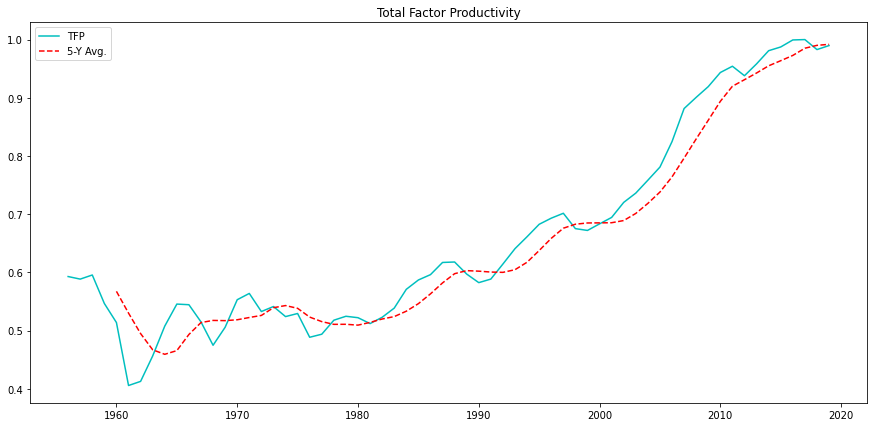

In [9]:
#Let's plot the TFP level till today and its projection
plt.figure(figsize=(15,7))
plt.plot(tfp, color='c')
plt.plot(tfp.rolling(5).mean(), color='r', linestyle='--')
plt.title('Total Factor Productivity')
plt.legend(['TFP', '5-Y Avg.'])
plt.show()

In [10]:
#Fetching and cleaning labor force data (Annual)
labor_force = fetch_series('WB/JOBS/SL.TLF.TOTL.IN-CN')

labor_force = clean_data(labor_force, 'Labor Force (Annual)')

labor_force.tail()

Labor Force (Annual)
period                          
2016-01-01           786996409.0
2017-01-01           787183156.0
2018-01-01           785986113.0
2019-01-01           783981188.0
2020-01-01           770950792.0

In [11]:
#Fetching and cleaning unemployment rate data (SA)
unemp_rate = fetch_series('WB/JOBS/SL.UEM.TOTL.ZS-CN')
unemp_rate = clean_data(unemp_rate, 'Unemployment Rate (Annual)')
unemp_rate.tail()

Unemployment Rate (Annual)
period                                
2016-01-01                         4.5
2017-01-01                         4.4
2018-01-01                         4.3
2019-01-01                         4.6
2020-01-01                         5.0

In [12]:
#Merging the two above dataframes
labor_supply = pd.concat([labor_force, unemp_rate], axis=1)
labor_supply.tail()

Labor Force (Annual)  Unemployment Rate (Annual)
period                                                      
2016-01-01           786996409.0                         4.5
2017-01-01           787183156.0                         4.4
2018-01-01           785986113.0                         4.3
2019-01-01           783981188.0                         4.6
2020-01-01           770950792.0                         5.0

In [13]:
#Calculate the Employment rate
labor_supply['Employment Rate'] = 100 - labor_supply['Unemployment Rate (Annual)']
labor_supply.head()

Labor Force (Annual)  Unemployment Rate (Annual)  Employment Rate
period                                                                       
1995-01-01           692423739.0                         3.0             97.0
1996-01-01           705042238.0                         3.1             96.9
1997-01-01           713343974.0                         3.2             96.8
1998-01-01           719231395.0                         3.2             96.8
1999-01-01           725914219.0                         3.3             96.7

In [14]:
#Calculate the Employment level (in thousands)
labor_supply['Employment (L)'] = (labor_supply['Labor Force (Annual)'] * labor_supply['Employment Rate']) / 100
labor_supply['Log Employment (L)'] = np.log(labor_supply['Employment (L)']).values
labor_supply.tail()

Labor Force (Annual)  Unemployment Rate (Annual)  Employment Rate  \
period                                                                          
2016-01-01           786996409.0                         4.5             95.5   
2017-01-01           787183156.0                         4.4             95.6   
2018-01-01           785986113.0                         4.3             95.7   
2019-01-01           783981188.0                         4.6             95.4   
2020-01-01           770950792.0                         5.0             95.0   

            Employment (L)  Log Employment (L)  
period                                          
2016-01-01    7.515816e+08           20.437690  
2017-01-01    7.525471e+08           20.438974  
2018-01-01    7.521887e+08           20.438498  
2019-01-01    7.479181e+08           20.432804  
2020-01-01    7.324033e+08           20.411842

In [15]:
#Estimating with the Hodrick-Prescott filter the potential Employment level (L*)
cycle, trend = sm.tsa.filters.hpfilter(labor_supply['Log Employment (L)'], 6.25)
labor_decomp = labor_supply[['Log Employment (L)']]
labor_decomp["cycle"] = cycle
labor_decomp["trend"] = trend

In [16]:
#Fetch the annual data for the labor force rate and calculate its 5-Y rolling mean
labor_force_rate = fetch_series('WB/JOBS/SL.TLF.CACT.ZS-CN')
labor_force_rate = clean_data(labor_force_rate, 'Labor Force Part. Rate (%)')
labor_force_rate['5-Y Avg'] = labor_force_rate['Labor Force Part. Rate (%)'].rolling(5).mean()
labor_force_rate.tail()

Labor Force Part. Rate (%)  5-Y Avg
period                                         
2016-01-01                       69.61   70.264
2017-01-01                       69.19   69.934
2018-01-01                       68.72   69.560
2019-01-01                       68.24   69.148
2020-01-01                       66.82   68.516

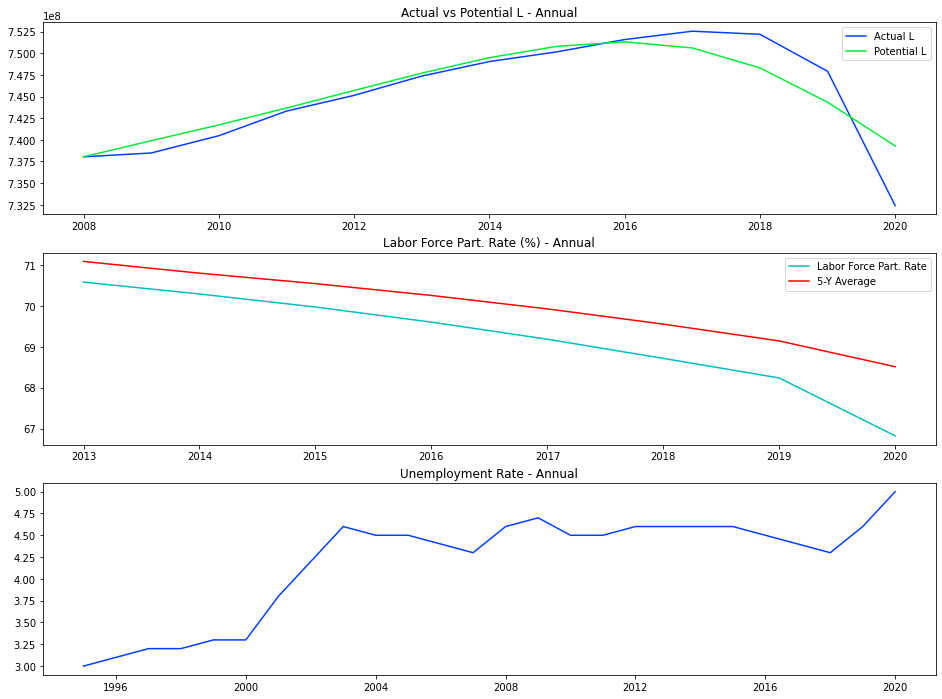

In [17]:
#Plot the actual vs potential Labor level, the labor force part. rate
plt.figure(figsize=(16,12))

plt.subplot(311)
plt.plot(labor_supply['Employment (L)']["2008-01-01":])
plt.plot(np.exp(labor_decomp["trend"]["2008-01-01":]))
plt.title('Actual vs Potential L - Annual')
plt.legend(['Actual L', 'Potential L'])

plt.subplot(312)
plt.plot(labor_force_rate['Labor Force Part. Rate (%)'][-8:], color='c')
plt.plot(labor_force_rate['5-Y Avg'][-8:], color='r')
plt.title('Labor Force Part. Rate (%) - Annual')
plt.legend(['Labor Force Part. Rate', '5-Y Average'])

plt.subplot(313)
plt.plot(labor_supply["Unemployment Rate (Annual)"][start:])
plt.title('Unemployment Rate - Annual')


plt.show()

# Section 2: Output Gap

In this section our goal is to understand if the economy is running a positive or negative output gap. In the first case we should expect a more tightening approach from policymakers, while in the second one a more dovish attitude.

In [18]:
#Fetch annual data with projections for the output growth from World Bank
output_gwth = fetch_series('WB/GEP/NYGDPMKTPKDZ-CN')
output_gwth = clean_data(output_gwth, 'Output Growth Prospects')
output_gwth.tail()

Output Growth Prospects
period                             
2019-01-01                      6.0
2020-01-01                      2.3
2021-01-01                      8.5
2022-01-01                      5.4
2023-01-01                      5.3

In [19]:
#Fetch data for quarterly real GDP
real_gdp = fetch_series('OECD/QNA/CHN.B1_GA.CQR.Q')
real_gdp = clean_data(real_gdp, 'Real GDP')
real_gdp['Log Real GDP'] = np.log(real_gdp['Real GDP']).values
real_gdp.tail()

Real GDP  Log Real GDP
period                              
2020-04-01  24898510.0     17.030319
2020-07-01  26497630.0     17.092566
2020-10-01  29629780.0     17.204290
2021-01-01  24931010.0     17.031623
2021-04-01  28285740.0     17.157868

In [20]:
#Estimating the potential GDP with HP fillter
cycle, trend = sm.tsa.filters.hpfilter(real_gdp['Log Real GDP'], 1600)
gdp_decomp = real_gdp[['Log Real GDP']]
gdp_decomp["cycle"] = cycle
gdp_decomp["trend"] = trend

In [21]:
gdp_decomp.tail()

Log Real GDP     cycle      trend
period                                       
2020-04-01     17.030319 -0.033383  17.063702
2020-07-01     17.092566  0.010453  17.082113
2020-10-01     17.204290  0.103772  17.100519
2021-01-01     17.031623 -0.087273  17.118896
2021-04-01     17.157868  0.020583  17.137286

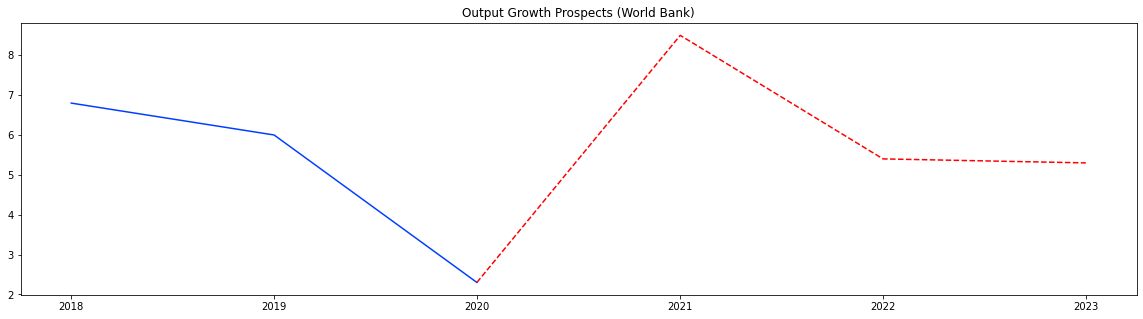

In [22]:
#Plot current and projected output gap and actual vs potential GDP
plt.figure(figsize=(20,5))

plt.plot(output_gwth.loc[:today])
plt.plot(output_gwth.loc[today:], color='r', linestyle='--')
plt.title('Output Growth Prospects (World Bank)')

plt.show()

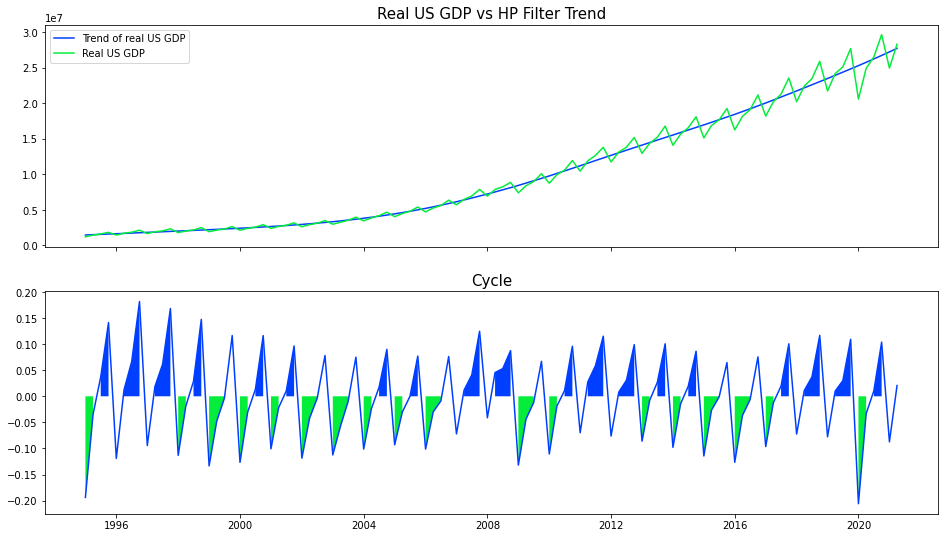

In [23]:
#Plot output gap and cycles
fig,ax = plt.subplots(2,1,sharex = True, figsize = (16,9))

df_trend = pd.Series(index = gdp_decomp.index, data = np.exp(gdp_decomp['trend']))
df_cycle = pd.Series(index = gdp_decomp.index, data = gdp_decomp['cycle'])

zero = [0 for t in gdp_decomp['trend']]

ax[0].plot(df_trend);
ax[0].plot(real_gdp['Real GDP']);
ax[0].legend(['Trend of real US GDP','Real US GDP']);
ax[1].plot(df_cycle)
ax[1].fill_between(real_gdp.index,zero,df_cycle,where=df_cycle > 0);
ax[1].fill_between(real_gdp.index,zero,df_cycle,where=df_cycle < 0);

ax[0].set_title('Real US GDP vs HP Filter Trend',size = 15)
ax[1].set_title('Cycle',size = 15);

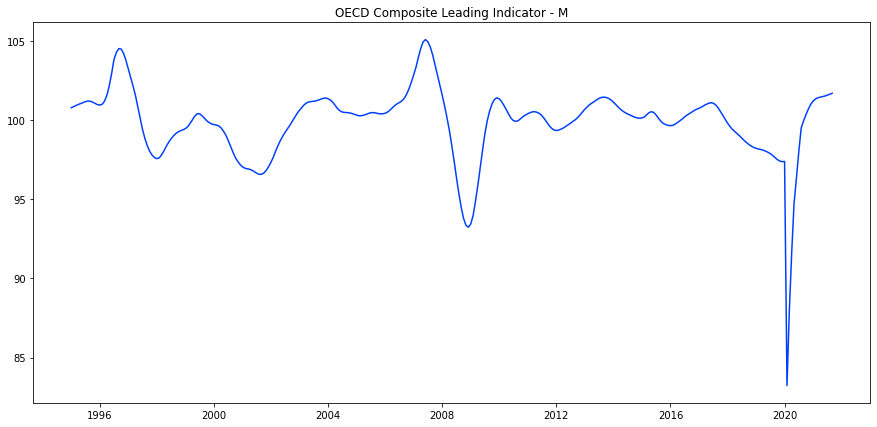

In [24]:
#Download data for OECD Composite Leading Indicator
oecd_cli = fetch_series('OECD/MEI_CLI/LOLITOAA.CHN.M')
oecd_cli = clean_data(oecd_cli, 'OECD CLI')

#Plot data for OECD Composite Leading Indicator
plt.figure(figsize=(15,7))
plt.plot(oecd_cli)
plt.title('OECD Composite Leading Indicator - M')
plt.show()

The composite leading indicator (CLI) is designed to provide early signals of turning points in business cycles showing fluctuation of the economic activity around its long term potential level. CLIs show short-term economic movements in qualitative rather than quantitative terms.

# Section 3: Aggregate Demand Analysis

In this section we are going to analyze the components of aggregate demand to understand from where the positive or negative growth is coming from. We will also look in more detail at Consumer Confidence Indicator.

In [25]:
#Let's fetch Aggregate Demand components data and store them in a dataframe
agg_dem_list = ['IMF/IFS/A.CN.NGDP_R_XDC',
                'IMF/IFS/A.CN.NCP_R_XDC',
                'IMF/IFS/A.CN.NCGG_R_XDC',
                'IMF/IFS/A.CN.NFI_R_XDC',
                'IMF/IFS/A.CN.NINV_R_XDC',
                'IMF/IFS/A.CN.NX_R_XDC',
                'IMF/IFS/A.CN.NM_R_XDC',
                'IMF/IFS/A.CN.NSDGDP_R_XDC']



agg_dem = pd.DataFrame()

for i in agg_dem_list:
    agg_dem = agg_dem.append(fetch_series(i)[['period', 'series_name', 'value']])
    

agg_dem = agg_dem.pivot(index='period', columns='series_name', values='value')
agg_dem.tail()

series_name  Annual – China – National Accounts, Expenditure, Gross Domestic Product, External Balance of Goods and Services, Exports of Goods and Services, Real, Domestic Currency, Millions  \
period                                                                                                                                                                                           
2015-01-01                                        1.471040e+07                                                                                                                                   
2016-01-01                                        1.460387e+07                                                                                                                                   
2017-01-01                                        1.579960e+07                                                                                                                                   
2018-01-01                                        1.646511e+07                                                                                                                                   
2019-01-01                                        1.689300e+07                                                                                                                                   

series_name  Annual – China – National Accounts, Expenditure, Gross Domestic Product, External Balance of Goods and Services, Imports of Goods and Services, Real, Domestic Currency, Millions  \
period                                                                                                                                                                                           
2015-01-01                                        1.247575e+07                                                                                                                                   
2016-01-01                                        1.291905e+07                                                                                                                                   
2017-01-01                                        1.386819e+07                                                                                                                                   
2018-01-01                                        1.492873e+07                                                                                                                                   
2019-01-01                                        1.478900e+07                                                                                                                                   

series_name  Annual – China – National Accounts, Expenditure, Gross Domestic Product, Final Consumption Expenditure, Private Sector (Households and Non-profit Institutions Serving Households), Real, Domestic Currency, Millions  \
period                                                                                                                                                                                                                               
2015-01-01                                        2.602024e+07                                                                                                                                                                       
2016-01-01                                        2.834930e+07                                                                                                                                                                       
2017-01-01                                        3.041558e+07                                                                                                                                                                       
2018-01-01                                        3.275514e+07                                                                      

In [26]:
#Rename columns
col_names = ['exports', 'imports',  'priv_cons', 'gov_cons', 'chg_inv', 'gfcf', 'Real GDP', 'res_item']

agg_dem.columns = col_names
agg_dem.tail()

exports       imports     priv_cons      gov_cons  \
period                                                               
2015-01-01  1.471040e+07  1.247575e+07  2.602024e+07  1.117182e+07   
2016-01-01  1.460387e+07  1.291905e+07  2.834930e+07  1.199486e+07   
2017-01-01  1.579960e+07  1.386819e+07  3.041558e+07  1.288259e+07   
2018-01-01  1.646511e+07  1.492873e+07  3.275514e+07  1.406039e+07   
2019-01-01  1.689300e+07  1.478900e+07  3.484473e+07  1.495289e+07   

                  chg_inv          gfcf      Real GDP     res_item  
period                                                              
2015-01-01  785627.905081  2.899702e+07  6.920937e+07     0.000008  
2016-01-01  807793.904808  3.110785e+07  7.394936e+07  4739.989183  
2017-01-01  906738.581258  3.294571e+07  7.908677e+07  4739.989183  
2018-01-01  782774.568058  3.528502e+07  8.442494e+07  5239.989183  
2019-01-01  580944.206222  3.709629e+07  8.958341e+07  4552.460838

In [27]:
#Calculate Net Exports
agg_dem['net_exports'] = agg_dem['exports'] - agg_dem['imports']
agg_dem.tail()

exports       imports     priv_cons      gov_cons  \
period                                                               
2015-01-01  1.471040e+07  1.247575e+07  2.602024e+07  1.117182e+07   
2016-01-01  1.460387e+07  1.291905e+07  2.834930e+07  1.199486e+07   
2017-01-01  1.579960e+07  1.386819e+07  3.041558e+07  1.288259e+07   
2018-01-01  1.646511e+07  1.492873e+07  3.275514e+07  1.406039e+07   
2019-01-01  1.689300e+07  1.478900e+07  3.484473e+07  1.495289e+07   

                  chg_inv          gfcf      Real GDP     res_item  \
period                                                               
2015-01-01  785627.905081  2.899702e+07  6.920937e+07     0.000008   
2016-01-01  807793.904808  3.110785e+07  7.394936e+07  4739.989183   
2017-01-01  906738.581258  3.294571e+07  7.908677e+07  4739.989183   
2018-01-01  782774.568058  3.528502e+07  8.442494e+07  5239.989183   
2019-01-01  580944.206222  3.709629e+07  8.958341e+07  4552.460838   

             net_exports  
period                    
2015-01-01  2.234649e+06  
2016-01-01  1.684811e+06  
2017-01-01  1.931406e+06  
2018-01-01  1.536381e+06  
2019-01-01  2.104000e+06

In [28]:
#Calculate aggregate demand components as a percentage of GDP
agg_dem_pct = pd.DataFrame()
agg_dem_pct['Private Consumption - %GDP'] = agg_dem['priv_cons'] / agg_dem['Real GDP']
agg_dem_pct['Government Consumption - %GDP'] = agg_dem['gov_cons'] / agg_dem['Real GDP']
agg_dem_pct['Gross Fixed Capital Formation - %GDP'] = agg_dem['gfcf'] / agg_dem['Real GDP']
agg_dem_pct['Change in Inventories - %GDP'] = agg_dem['chg_inv'] / agg_dem['Real GDP']
agg_dem_pct['Net Exports - %GDP'] = agg_dem['net_exports'] / agg_dem['Real GDP']
agg_dem_pct['Residual Item - %GDP'] = agg_dem['res_item'] / agg_dem['Real GDP']
agg_dem_pct.tail()

Private Consumption - %GDP  Government Consumption - %GDP  \
period                                                                  
2015-01-01                    0.375964                       0.161421   
2016-01-01                    0.383361                       0.162204   
2017-01-01                    0.384585                       0.162892   
2018-01-01                    0.387979                       0.166543   
2019-01-01                    0.388964                       0.166916   

            Gross Fixed Capital Formation - %GDP  \
period                                             
2015-01-01                              0.418975   
2016-01-01                              0.420664   
2017-01-01                              0.416577   
2018-01-01                              0.417945   
2019-01-01                              0.414098   

            Change in Inventories - %GDP  Net Exports - %GDP  \
period                                                         
2015-01-01                      0.011351            0.032288   
2016-01-01                      0.010924            0.022783   
2017-01-01                      0.011465            0.024421   
2018-01-01                      0.009272            0.018198   
2019-01-01                      0.006485            0.023486   

            Residual Item - %GDP  
period                            
2015-01-01          1.185262e-13  
2016-01-01          6.409777e-05  
2017-01-01          5.993404e-05  
2018-01-01          6.206684e-05  
2019-01-01          5.081813e-05

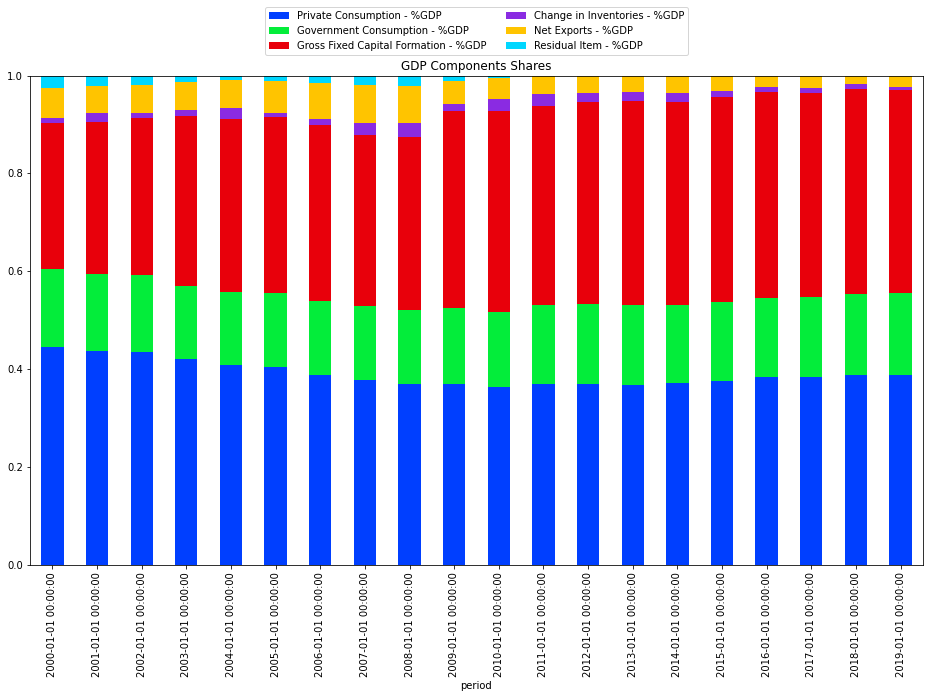

In [29]:
#Plot the components of AD in a stacked barchart
ax = agg_dem_pct.iloc[-20:].plot.bar(stacked=True, figsize=(16,9), title='GDP Components Shares')
ax = plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol= 2)
plt.show()

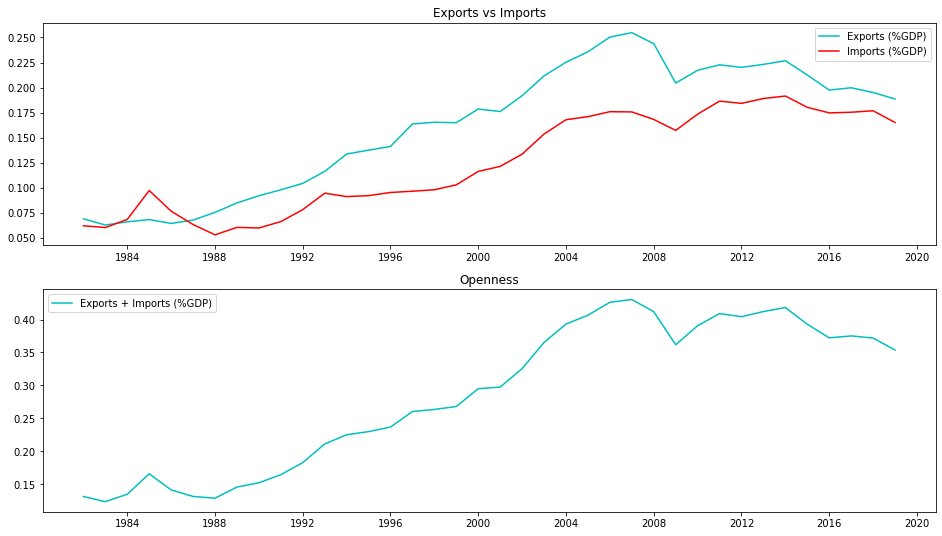

In [30]:
#Plot the Exports and Imports time series and the "Openness" of the economy as the sum of the two previous items
plt.figure(figsize=(16,9))
plt.subplot(211)
plt.plot((agg_dem['exports'] / agg_dem['Real GDP']), color='c')
plt.plot((agg_dem['imports'] / agg_dem['Real GDP']), color='r')
plt.title('Exports vs Imports')
plt.legend(['Exports (%GDP)', 'Imports (%GDP)'])
plt.subplot(212)
plt.plot((((agg_dem['exports'] / agg_dem['Real GDP']) + (agg_dem['imports'] / agg_dem['Real GDP']))), color='c')
plt.title('Openness')
plt.legend(['Exports + Imports (%GDP)'], loc='upper left')
plt.show()

In [31]:
#Calculate how each component of AD contributed to GDP growth
growth_contr = pd.DataFrame()
growth_contr['GDP Growth (YoY)'] = agg_dem['Real GDP'].pct_change(4)
growth_contr['Priv. Cons. Contr.'] = agg_dem['priv_cons'].diff(4) / agg_dem['Real GDP'].shift(4)
growth_contr['Gov. Cons. Contr.'] = agg_dem['gov_cons'].diff(4) / agg_dem['Real GDP'].shift(4)
growth_contr['GFCF Contr.'] = agg_dem['gfcf'].diff(4) / agg_dem['Real GDP'].shift(4)
growth_contr['Chg. Inv. Contr.'] = agg_dem['chg_inv'].diff(4) / agg_dem['Real GDP'].shift(4)
growth_contr['Net Exp. Contr.'] = agg_dem['net_exports'].diff(4) / agg_dem['Real GDP'].shift(4)
growth_contr['Res. Item Contr.'] = agg_dem['res_item'].diff(4) / agg_dem['Real GDP'].shift(4)
growth_contr = growth_contr.dropna()
growth_contr.head()

GDP Growth (YoY)  Priv. Cons. Contr.  Gov. Cons. Contr.  \
period                                                                
1986-01-01          0.577686            0.287335           0.090635   
1987-01-01          0.590501            0.266116           0.071420   
1988-01-01          0.535275            0.234772           0.035325   
1989-01-01          0.409463            0.168677           0.032092   
1990-01-01          0.344596            0.149422           0.041666   

            GFCF Contr.  Chg. Inv. Contr.  Net Exp. Contr.  Res. Item Contr.  
period                                                                        
1986-01-01     0.173569          0.062797        -0.026214         -0.010437  
1987-01-01     0.162580          0.061130         0.004552          0.024703  
1988-01-01     0.158062          0.064972         0.036798          0.005346  
1989-01-01     0.041012          0.068593         0.063544          0.035544  
1990-01-01    -0.003232          0.059143         0.055497          0.042101

In [32]:
#The following dataframe is identical to the above one, but with the "period" index set as a column instead of as the index. This is done simply to plot it below in a combined chart
df_to_plot = growth_contr.reset_index()
df_to_plot.head()

period  GDP Growth (YoY)  Priv. Cons. Contr.  Gov. Cons. Contr.  \
0 1986-01-01          0.577686            0.287335           0.090635   
1 1987-01-01          0.590501            0.266116           0.071420   
2 1988-01-01          0.535275            0.234772           0.035325   
3 1989-01-01          0.409463            0.168677           0.032092   
4 1990-01-01          0.344596            0.149422           0.041666   

   GFCF Contr.  Chg. Inv. Contr.  Net Exp. Contr.  Res. Item Contr.  
0     0.173569          0.062797        -0.026214         -0.010437  
1     0.162580          0.061130         0.004552          0.024703  
2     0.158062          0.064972         0.036798          0.005346  
3     0.041012          0.068593         0.063544          0.035544  
4    -0.003232          0.059143         0.055497          0.042101

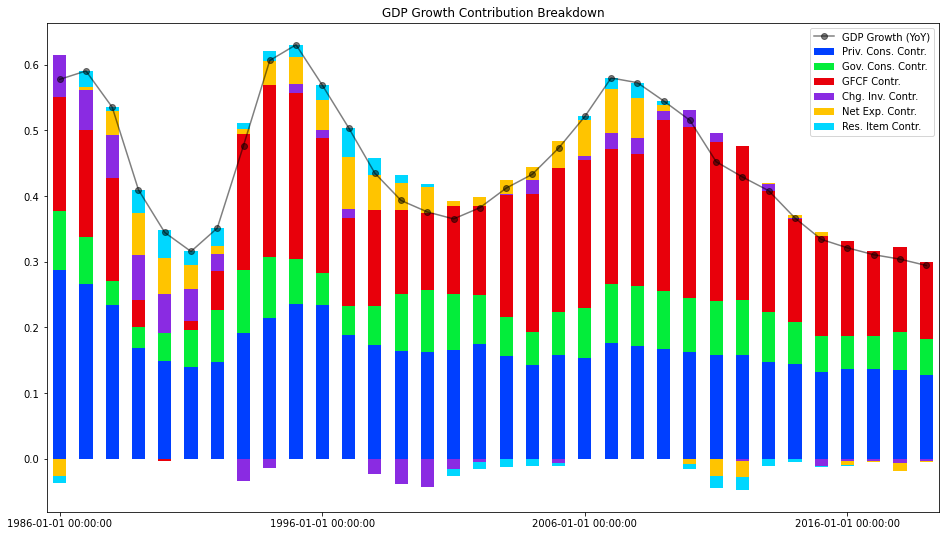

In [33]:
#Plot the contribution of AD components in a stacked chart together with the evolution of GDP growth
fig, ax1 = plt.subplots(figsize = (16, 9))

df_to_plot[['Priv. Cons. Contr.', 
              'Gov. Cons. Contr.', 
              'GFCF Contr.', 
              'Chg. Inv. Contr.', 
              'Net Exp. Contr.', 
              'Res. Item Contr.']].\
         plot(kind = 'bar', stacked = True, ax = ax1)
df_to_plot['GDP Growth (YoY)'].plot(linestyle='-', marker='o', color='black', alpha=0.5, ax = ax1, legend=True)
leg = plt.legend(loc='upper right')
tit = plt.title('GDP Growth Contribution Breakdown')
ax1.set_xticklabels(labels = df_to_plot['period'])
ax1.set_xticks(np.arange(0, len(df_to_plot)+1, 10))
plt.show()

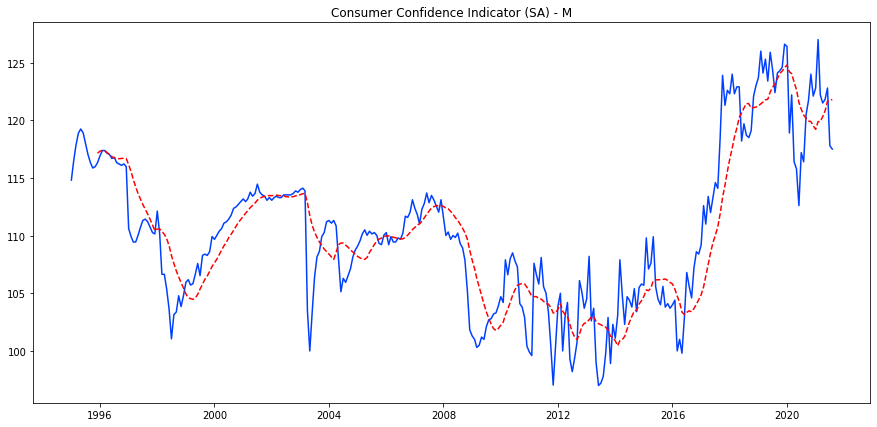

In [34]:
#Fetch Consumer Confidence Indicator data
cci = fetch_series('OECD/KEI/CSCICP02.CHN.ST.M')
cci = clean_data(cci, 'Consumer Confidence Indicator (SA) - M')

#Plot Consumer Confidence Indicator data
plt.figure(figsize=(15,7))
plt.plot(cci)
plt.plot(cci.rolling(12).mean(), color='r', linestyle='--')
plt.title('Consumer Confidence Indicator (SA) - M')
plt.show()

In [35]:
cci.tail()

Consumer Confidence Indicator (SA) - M
period                                            
2021-04-01                                   121.5
2021-05-01                                   121.8
2021-06-01                                   122.8
2021-07-01                                   117.8
2021-08-01                                   117.5

# Section 4: Inflation Analysis

In this section our goal is to assess inflation pressures from different perspectives. In fact, after analyzing different measures of inflations (CPI and PPI), we will analyze residential property prices, as well as important commodities imported by the country such as oil and other used in real estate development (base metals).  

In [36]:
#Fetch monthly inflation rate (YoY chg) series
cpi_yoy_m = fetch_series('IMF/CPI/M.CN.PCPI_PC_CP_A_PT')
cpi_yoy_m = clean_data(cpi_yoy_m, 'Inflation Rate YoY - (M)')
cpi_yoy_m['Target'] = 3
cpi_yoy_m.tail()

Inflation Rate YoY - (M)  Target
period                                      
2021-04-01                  0.922645       3
2021-05-01                  1.644355       3
2021-06-01                  1.240203       3
2021-07-01                  1.912559       3
2021-08-01                  0.641575       3

In [37]:
#Fetch monthly inflation rate (MoM chg) series
cpi_mom_m = fetch_series('IMF/CPI/M.CN.PCPI_PC_PP_PT')
cpi_mom_m = clean_data(cpi_mom_m, 'Inflation Rate MoM - (M)')
cpi_mom_m['Rolling 12-M Avg'] = cpi_mom_m['Inflation Rate MoM - (M)'].rolling(12).mean() 
cpi_mom_m.tail()

Inflation Rate MoM - (M)  Rolling 12-M Avg
period                                                
2021-04-01                 -0.297030          0.078709
2021-05-01                 -0.099305          0.137819
2021-06-01                 -0.397614          0.104685
2021-07-01                  0.299401          0.159828
2021-08-01                  0.099502          0.054483

In [38]:
#Fetch Producer Prices Index: Economic activities: Industrial activities: Total for China data
ppi_df = eco_cal_data_pct(event='PPI')
ppi_df['12-M Avg.'] = ppi_df.rolling(12).mean()
ppi_df.columns = ['PPI', '12-M Avg.']

ppi_df.tail()

PPI  12-M Avg.
date                       
2021-06-09   9.0   0.725000
2021-07-09   8.8   1.708333
2021-08-09   9.0   2.658333
2021-09-09   9.5   3.616667
2021-10-14  10.7   4.683333

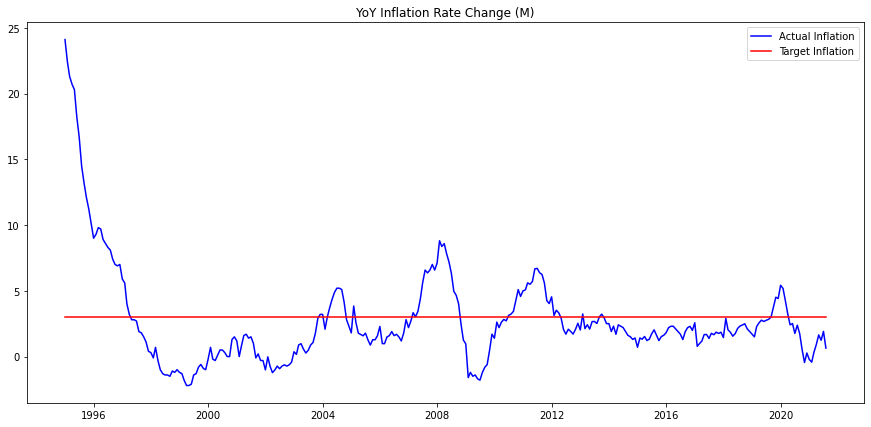

In [39]:
#Plot YoY monthly inflation change
plt.figure(figsize=(15,7))
plt.plot(cpi_yoy_m['Inflation Rate YoY - (M)'], color='blue')
plt.plot(cpi_yoy_m['Target'], color='red')
plt.legend(['Actual Inflation', 'Target Inflation'])
plt.title('YoY Inflation Rate Change (M)')
plt.show()

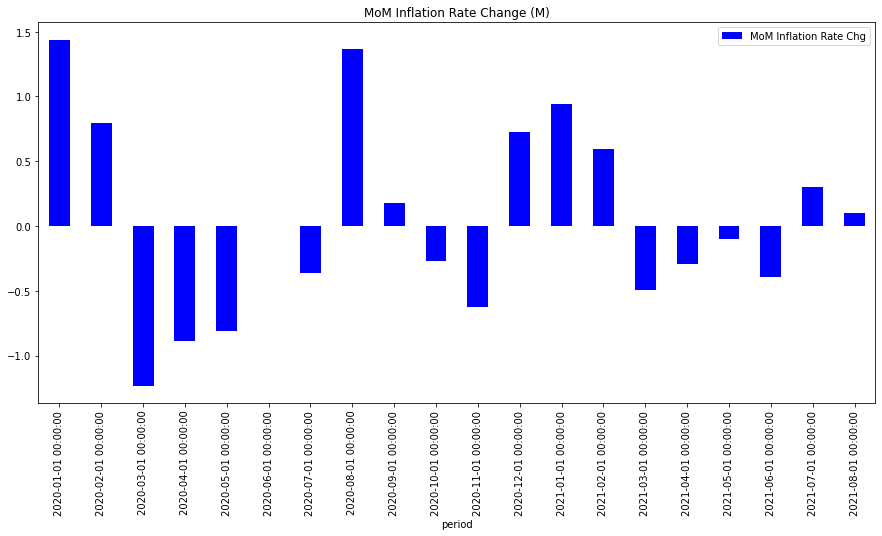

In [40]:
#Plot MoM monthly inflation change
cpi_mom_m['Inflation Rate MoM - (M)'].iloc[-20:].plot(kind='bar', color='blue', figsize=(15,7))
plt.legend(['MoM Inflation Rate Chg'])
plt.title('MoM Inflation Rate Change (M)')
plt.show()

In [41]:
#Plot PPI data
plt.figure(figsize=(15,7))
fig = px.line(ppi_df, x=ppi_df.index, y=['PPI', '12-M Avg.'], title='Producer Prices Index')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

<Figure size 1080x504 with 0 Axes>

In [42]:
#Fetch Real Residential Property Prices for China data
real_prop_prices = fred.get_series('QCNR628BIS')
real_prop_prices_df = pd.DataFrame(real_prop_prices)
real_prop_prices_df['4-Q Avg.'] = real_prop_prices.rolling(4).mean()
real_prop_prices_df.columns=['Real Prop. Prices', '4-Q Avg.']
real_prop_prices_df = real_prop_prices_df.dropna()

#Plot Real Residential Property Prices for China data
plt.figure(figsize=(15,7))
fig = px.line(real_prop_prices_df, x=real_prop_prices_df.index, y=['Real Prop. Prices', '4-Q Avg.'], title='Real Residential Property Prices for China')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

<Figure size 1080x504 with 0 Axes>

In [43]:
#Fetch monthly base metals prices in $
base_metals = fetch_series('RBA/I2/GRCPBMUSD')
base_metals = clean_data(base_metals, 'Base Metals - $')
base_metals['Avg - Rol. 3M'] = base_metals['Base Metals - $'].rolling(3).mean()
base_metals['Avg - Rol. 12M'] = base_metals['Base Metals - $'].rolling(12).mean()
base_metals.tail()

Base Metals - $  Avg - Rol. 3M  Avg - Rol. 12M
period                                                    
2021-08-31       151.463077     149.250444      132.845095
2021-09-30       155.810231     152.038939      136.721767
2021-10-31              NaN            NaN             NaN
2021-11-30              NaN            NaN             NaN
2021-12-31              NaN            NaN             NaN

In [44]:
#Download oil futures data since China depends heavily on this commodity
lumber = yf.download('CL=F', period='5y', interval = "1mo")['Adj Close']


[*********************100%***********************]  1 of 1 completed


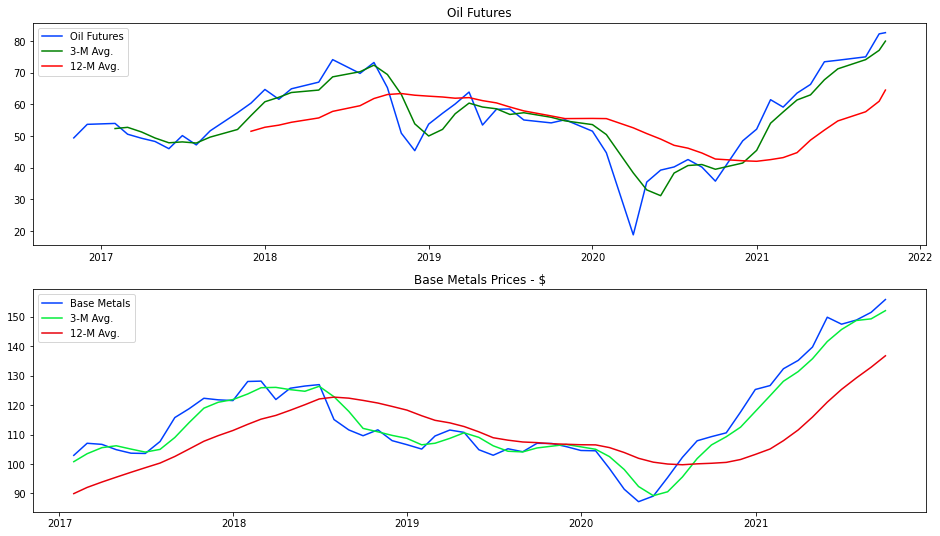

In [45]:
#Plot oil futures prices
plt.subplots(figsize=(16,9))
plt.subplot(211)
plt.plot(lumber)
plt.plot(lumber.rolling(3).mean(), color='g')
plt.plot(lumber.rolling(12).mean(), color='r')
plt.legend(['Oil Futures', '3-M Avg.', '12-M Avg.'])
plt.title('Oil Futures')

plt.subplot(212)
plt.plot(base_metals.iloc[-60:])
plt.title('Base Metals Prices - $')
plt.legend(['Base Metals', '3-M Avg.', '12-M Avg.'])
plt.show()

# Section 5: Monetary Policy Analysis  

In this section we are about to analyze how the monetary policy is and how it should presumably evolve over time. Since China is a country operating under a monetary targeting framework, we will look at money overhang first and to Real Monetary Conditions Index (RMCI) later.

In [46]:
prime_rate = eco_cal_data_pct(event='PBoC Loan Prime Rate')
prime_rate.tail()

PBoC Loan Prime Rate
date                            
2021-05-20                  3.85
2021-06-21                  3.85
2021-07-20                  3.85
2021-08-20                  3.85
2021-09-22                  3.85

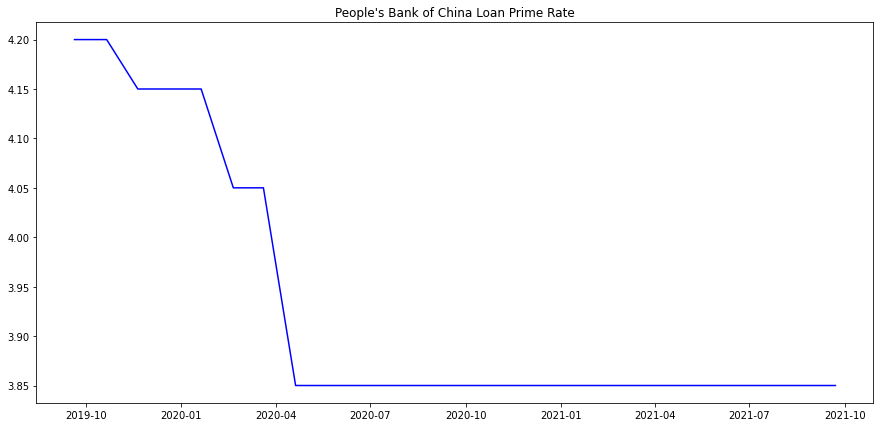

In [47]:
#Plot PBOC interest rate data
plt.figure(figsize=(15,7))
plt.plot(prime_rate, color='b')
plt.title("People's Bank of China Loan Prime Rate")
plt.show()

In [48]:
#Let's create a DataFrame to calculate the variables for money overhang
mo = pd.DataFrame(index=real_gdp.index)
mo['real_gdp'] = real_gdp['Real GDP']

cycle, trend = sm.tsa.filters.hpfilter(mo['real_gdp'], 1600)

mo['gdp_trend'] = trend

#Fetch money supply (M2) and quarterly CPI data
m2 = fetch_series('IMF/MFS/Q.CN.35L___XDC')
m2 = clean_data(m2, 'Money Supply')

cpi_q = fetch_series('IMF/CPI/Q.CN.PCPI_IX')
cpi_q = clean_data(cpi_q, 'CPI - Q')

#Add other inputs to money overhang df
mo['m2'] = m2
mo['cpi'] = cpi_q

#Let's drop NA rows (unfortunately data for M2 lags 2 quarters)
mo = mo.dropna()
mo.tail()

real_gdp     gdp_trend            m2         cpi
period                                                        
2020-01-01  20572700.0  2.531259e+07  2.040798e+08  101.243667
2020-04-01  24898510.0  2.574798e+07  2.094563e+08   99.241490
2020-07-01  26497630.0  2.618531e+07  2.128564e+08   99.570213
2020-10-01  29629780.0  2.662332e+07  2.147664e+08   99.689737
2021-01-01  24931010.0  2.706099e+07  2.236289e+08  101.133333

In [49]:
#Let's calculate the log of GDP, M2 and CPI
mo['log_gdp'] = np.log(mo['real_gdp']).values
mo['log_m2'] = np.log(mo['m2']).values
mo['log_cpi'] = np.log(mo['cpi']).values
mo.tail()

real_gdp     gdp_trend            m2         cpi    log_gdp  \
period                                                                      
2020-01-01  20572700.0  2.531259e+07  2.040798e+08  101.243667  16.839476   
2020-04-01  24898510.0  2.574798e+07  2.094563e+08   99.241490  17.030319   
2020-07-01  26497630.0  2.618531e+07  2.128564e+08   99.570213  17.092566   
2020-10-01  29629780.0  2.662332e+07  2.147664e+08   99.689737  17.204290   
2021-01-01  24931010.0  2.706099e+07  2.236289e+08  101.133333  17.031623   

               log_m2   log_cpi  
period                           
2020-01-01  19.134021  4.617530  
2020-04-01  19.160026  4.597556  
2020-07-01  19.176128  4.600863  
2020-10-01  19.185061  4.602063  
2021-01-01  19.225498  4.616440

In [50]:
#Calculate velocity
mo['log_v'] = mo['log_gdp'] + mo['log_cpi'] - mo['log_m2']
mo.tail()

real_gdp     gdp_trend            m2         cpi    log_gdp  \
period                                                                      
2020-01-01  20572700.0  2.531259e+07  2.040798e+08  101.243667  16.839476   
2020-04-01  24898510.0  2.574798e+07  2.094563e+08   99.241490  17.030319   
2020-07-01  26497630.0  2.618531e+07  2.128564e+08   99.570213  17.092566   
2020-10-01  29629780.0  2.662332e+07  2.147664e+08   99.689737  17.204290   
2021-01-01  24931010.0  2.706099e+07  2.236289e+08  101.133333  17.031623   

               log_m2   log_cpi     log_v  
period                                     
2020-01-01  19.134021  4.617530  2.322984  
2020-04-01  19.160026  4.597556  2.467849  
2020-07-01  19.176128  4.600863  2.517301  
2020-10-01  19.185061  4.602063  2.621292  
2021-01-01  19.225498  4.616440  2.422564

In [51]:
#Calculate log of GDP trend
mo['log_gdp_trend'] = np.log(mo['gdp_trend']).values

#Calculate the trend of v
cycle, trend = sm.tsa.filters.hpfilter(mo['log_v'], 1600)
mo['v_trend'] = trend
mo.tail()

real_gdp     gdp_trend            m2         cpi    log_gdp  \
period                                                                      
2020-01-01  20572700.0  2.531259e+07  2.040798e+08  101.243667  16.839476   
2020-04-01  24898510.0  2.574798e+07  2.094563e+08   99.241490  17.030319   
2020-07-01  26497630.0  2.618531e+07  2.128564e+08   99.570213  17.092566   
2020-10-01  29629780.0  2.662332e+07  2.147664e+08   99.689737  17.204290   
2021-01-01  24931010.0  2.706099e+07  2.236289e+08  101.133333  17.031623   

               log_m2   log_cpi     log_v  log_gdp_trend   v_trend  
period                                                              
2020-01-01  19.134021  4.617530  2.322984      17.046812  2.502967  
2020-04-01  19.160026  4.597556  2.467849      17.063867  2.505427  
2020-07-01  19.176128  4.600863  2.517301      17.080709  2.507863  
2020-10-01  19.185061  4.602063  2.621292      17.097298  2.510256  
2021-01-01  19.225498  4.616440  2.422564      17.113604  2.512592

In [52]:
#Let's calculate Q-o-Q annualized change for log variables
mo['gdp_qoq'] = (mo['log_gdp'] - mo['log_gdp'].shift(1)) * 4
mo['m2_qoq'] = (mo['log_m2'] - mo['log_m2'].shift(1)) * 4
mo['cpi_qoq'] = (mo['log_cpi'] - mo['log_cpi'].shift(1)) * 4
mo['v_qoq'] = (mo['log_v'] - mo['log_v'].shift(1)) * 4
mo['gdp_trend_qoq'] = (mo['log_gdp_trend'] - mo['log_gdp_trend'].shift(1)) * 4
mo['v_trend_qoq'] = (mo['v_trend'] - mo['v_trend'].shift(1)) * 4
mo['infl_target'] = 0.03
mo.tail()

real_gdp     gdp_trend            m2         cpi    log_gdp  \
period                                                                      
2020-01-01  20572700.0  2.531259e+07  2.040798e+08  101.243667  16.839476   
2020-04-01  24898510.0  2.574798e+07  2.094563e+08   99.241490  17.030319   
2020-07-01  26497630.0  2.618531e+07  2.128564e+08   99.570213  17.092566   
2020-10-01  29629780.0  2.662332e+07  2.147664e+08   99.689737  17.204290   
2021-01-01  24931010.0  2.706099e+07  2.236289e+08  101.133333  17.031623   

               log_m2   log_cpi     log_v  log_gdp_trend   v_trend   gdp_qoq  \
period                                                                         
2020-01-01  19.134021  4.617530  2.322984      17.046812  2.502967 -1.186952   
2020-04-01  19.160026  4.597556  2.467849      17.063867  2.505427  0.763372   
2020-07-01  19.176128  4.600863  2.517301      17.080709  2.507863  0.248989   
2020-10-01  19.185061  4.602063  2.621292      17.097298  2.510256  0.446899   
2021-01-01  19.225498  4.616440  2.422564      17.113604  2.512592 -0.690670   

              m2_qoq   cpi_qoq     v_qoq  gdp_trend_qoq  v_trend_qoq  \
period                                                                 
2020-01-01  0.177574  0.066669 -1.297858       0.068979     0.009954   
2020-04-01  0.104016 -0.079896  0.579460       0.068218     0.009839   
2020-07-01  0.064411  0.013228  0.197806       0.067369     0.009743   
2020-10-01  0.035733  0.004799  0.415964       0.066357     0.009570   
2021-01-01  0.161748  0.057508 -0.794910       0.065222     0.009345   

            infl_target  
period                   
2020-01-01         0.03  
2020-04-01         0.03  
2020-07-01         0.03  
2020-10-01         0.03  
2021-01-01         0.03

In [53]:
#Let's calculate Y-o-Y change for log variables
mo['gdp_yoy'] = (mo['log_gdp'] - mo['log_gdp'].shift(4))
mo['m2_yoy'] = (mo['log_m2'] - mo['log_m2'].shift(4))
mo['cpi_yoy'] = (mo['log_cpi'] - mo['log_cpi'].shift(4))
mo['v_yoy'] = (mo['log_v'] - mo['log_v'].shift(4))
mo['gdp_trend_yoy'] = (mo['log_gdp_trend'] - mo['log_gdp_trend'].shift(4))
mo['v_trend_yoy'] = (mo['v_trend'] - mo['v_trend'].shift(4))
mo.tail()

real_gdp     gdp_trend            m2         cpi    log_gdp  \
period                                                                      
2020-01-01  20572700.0  2.531259e+07  2.040798e+08  101.243667  16.839476   
2020-04-01  24898510.0  2.574798e+07  2.094563e+08   99.241490  17.030319   
2020-07-01  26497630.0  2.618531e+07  2.128564e+08   99.570213  17.092566   
2020-10-01  29629780.0  2.662332e+07  2.147664e+08   99.689737  17.204290   
2021-01-01  24931010.0  2.706099e+07  2.236289e+08  101.133333  17.031623   

               log_m2   log_cpi     log_v  log_gdp_trend   v_trend  ...  \
period                                                              ...   
2020-01-01  19.134021  4.617530  2.322984      17.046812  2.502967  ...   
2020-04-01  19.160026  4.597556  2.467849      17.063867  2.505427  ...   
2020-07-01  19.176128  4.600863  2.517301      17.080709  2.507863  ...   
2020-10-01  19.185061  4.602063  2.621292      17.097298  2.510256  ...   
2021-01-01  19.225498  4.616440  2.422564      17.113604  2.512592  ...   

               v_qoq  gdp_trend_qoq  v_trend_qoq  infl_target   gdp_yoy  \
period                                                                    
2020-01-01 -1.297858       0.068979     0.009954         0.03 -0.054123   
2020-04-01  0.579460       0.068218     0.009839         0.03  0.030513   
2020-07-01  0.197806       0.067369     0.009743         0.03  0.054003   
2020-10-01  0.415964       0.066357     0.009570         0.03  0.068077   
2021-01-01 -0.794910       0.065222     0.009345         0.03  0.192147   

              m2_yoy   cpi_yoy     v_yoy  gdp_trend_yoy  v_trend_yoy  
period                                                                
2020-01-01  0.093754  0.048377 -0.099499       0.070813     0.010896  
2020-04-01  0.103629  0.026855 -0.046261       0.069682     0.010387  
2020-07-01  0.103156  0.019395 -0.029758       0.068674     0.010018  
2020-10-01  0.095433  0.001200 -0.026157       0.067731     0.009777  
2021-01-01  0.091477 -0.001090  0.099580       0.066791     0.009625  

[5 rows x 23 columns]

In [54]:
#Let's calculate money overhnag, as well as long-run and short-run money target
mo['money_overhang'] = (mo['log_m2'] - mo['log_cpi']) - (mo['log_gdp_trend'] - mo['v_trend'])
mo['long_run_mt'] = mo['gdp_trend_yoy'] + mo['infl_target'] - mo['v_trend_yoy']
mo['short_run_mt'] = mo['long_run_mt'] - mo['money_overhang']
mo.tail()

real_gdp     gdp_trend            m2         cpi    log_gdp  \
period                                                                      
2020-01-01  20572700.0  2.531259e+07  2.040798e+08  101.243667  16.839476   
2020-04-01  24898510.0  2.574798e+07  2.094563e+08   99.241490  17.030319   
2020-07-01  26497630.0  2.618531e+07  2.128564e+08   99.570213  17.092566   
2020-10-01  29629780.0  2.662332e+07  2.147664e+08   99.689737  17.204290   
2021-01-01  24931010.0  2.706099e+07  2.236289e+08  101.133333  17.031623   

               log_m2   log_cpi     log_v  log_gdp_trend   v_trend  ...  \
period                                                              ...   
2020-01-01  19.134021  4.617530  2.322984      17.046812  2.502967  ...   
2020-04-01  19.160026  4.597556  2.467849      17.063867  2.505427  ...   
2020-07-01  19.176128  4.600863  2.517301      17.080709  2.507863  ...   
2020-10-01  19.185061  4.602063  2.621292      17.097298  2.510256  ...   
2021-01-01  19.225498  4.616440  2.422564      17.113604  2.512592  ...   

            infl_target   gdp_yoy    m2_yoy   cpi_yoy     v_yoy  \
period                                                            
2020-01-01         0.03 -0.054123  0.093754  0.048377 -0.099499   
2020-04-01         0.03  0.030513  0.103629  0.026855 -0.046261   
2020-07-01         0.03  0.054003  0.103156  0.019395 -0.029758   
2020-10-01         0.03  0.068077  0.095433  0.001200 -0.026157   
2021-01-01         0.03  0.192147  0.091477 -0.001090  0.099580   

            gdp_trend_yoy  v_trend_yoy  money_overhang  long_run_mt  \
period                                                                
2020-01-01       0.070813     0.010896       -0.027354     0.089917   
2020-04-01       0.069682     0.010387        0.004030     0.089296   
2020-07-01       0.068674     0.010018        0.002419     0.088656   
2020-10-01       0.067731     0.009777       -0.004044     0.087954   
2021-01-01       0.066791     0.009625        0.008047     0.087167   

            short_run_mt  
period                    
2020-01-01      0.117270  
2020-04-01      0.085266  
2020-07-01      0.086237  
2020-10-01      0.091998  
2021-01-01      0.079120  

[5 rows x 26 columns]

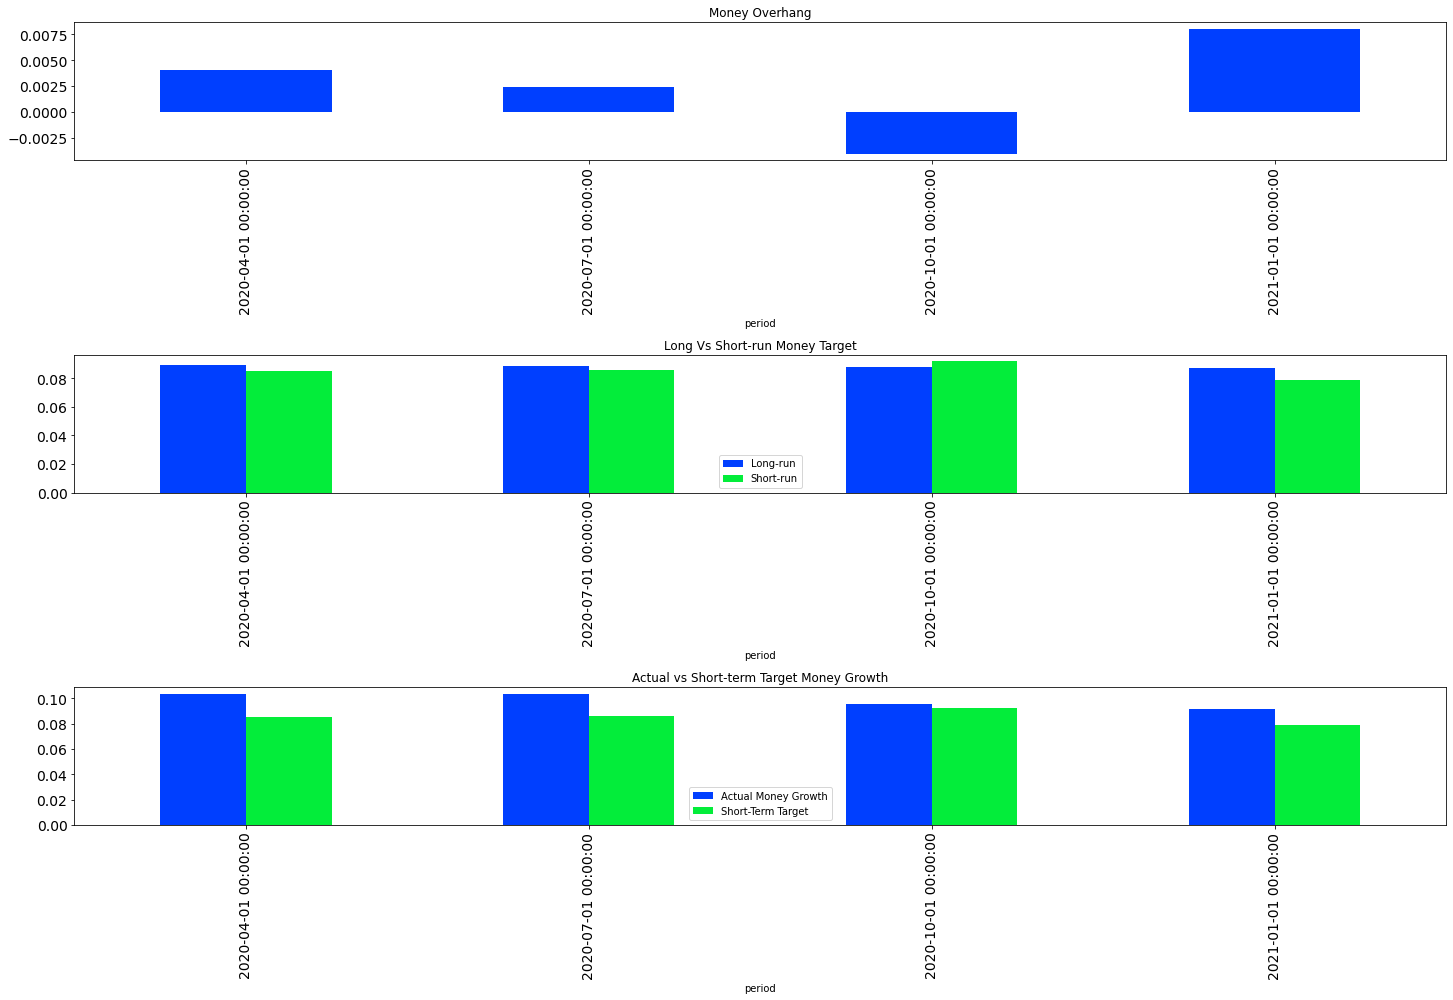

In [55]:
#Let's select data for the last four quarters
mo_to_plot = mo.iloc[-4:]

#Plot Money Overhang graph
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,14))


ax = mo_to_plot['money_overhang'].plot(ax=axes[0], kind='bar', title='Money Overhang', fontsize=14)

ax1 = mo_to_plot[['long_run_mt', 'short_run_mt']].plot(ax=axes[1], kind='bar', stacked=False, title='Long Vs Short-run Money Target', fontsize=14)
ax1.legend(['Long-run', 'Short-run'])

ax2 = mo_to_plot[['m2_yoy', 'short_run_mt']].plot(ax=axes[2], kind='bar', stacked=False, title='Actual vs Short-term Target Money Growth', fontsize=14)
ax2.legend(['Actual Money Growth', 'Short-Term Target'])


fig.subplots_adjust(bottom=0.6)

fig.tight_layout()

plt.show()

If Money Overhang is positive, then monetary policy should be less accomodative. If Money Overhang is negative, then monetary policy should be more accomodative.

If long-run intermediate money target is greater than short-run intermediate money target, then monetary policy should be less accomodative. If long-run intermediate money target is lesser than short-run intermediate money target, then monetary policy should be more accomodative.

If actual money growth is greater than short-run intermediate money, then should be less accomodative. If actual money growth is lesser than short-run intermediate money, then should be more accomodative.

In [57]:
#Fetch and organize data for the RMCI calculation
rmci = pd.DataFrame(index=cpi_q.index)

usd_cny = fetch_series('BIS/xru_current/Q.CN.CNY.A')
usd_cny = clean_data(usd_cny, 'USD/CNY')

rmci['cpi_dom'] = cpi_q
rmci['fx'] = usd_cny
rmci = rmci.dropna()

rmci['cpi_for'] = rmci['cpi_dom'] / rmci['fx']

exp_infl = fetch_series('OECD/EO/CHN.CPI_YTYPCT.Q')
exp_infl = clean_data(exp_infl, 'Exp Infl - Q')

rmci ['Exp. Infl. - Q'] = exp_infl.shift(-4)
rmci = rmci.dropna()

comm_rate = prime_rate['PBoC Loan Prime Rate'].resample('QS').mean()

rmci['Commercial Rate'] = comm_rate
rmci = rmci.dropna()
rmci.tail()

cpi_dom        fx    cpi_for  Exp. Infl. - Q  Commercial Rate
period                                                                      
2020-04-01   99.241490  7.089072  13.999222        1.482540             3.85
2020-07-01   99.570213  6.918142  14.392624        1.834690             3.85
2020-10-01   99.689737  6.624092  15.049570        2.932408             3.85
2021-01-01  101.133333  6.480761  15.605163        2.749085             3.85
2021-04-01  100.500000  6.455659  15.567737        2.498780             3.85

In [58]:
#Calculate the RMCI
a = 0.5 #Let's assume the value of alpha is 0.7

rmci['Real Comm. Rate'] = rmci['Commercial Rate'] - rmci['Exp. Infl. - Q']

cycle, trend = sm.tsa.filters.hpfilter(rmci['Real Comm. Rate'], 1600)

rmci['Real Int. Rate Trend'] = trend
rmci['Real Int. Rate Gap'] = rmci['Real Comm. Rate'] - rmci['Real Int. Rate Trend']
rmci['FC/LC'] = 1 * usd_cny
rmci['Real Exch. Rate'] = (np.log(rmci['FC/LC']).values + np.log(rmci['cpi_dom']).values - np.log(rmci['cpi_for'].values))*100

cycle_1, trend_1 = sm.tsa.filters.hpfilter(rmci['Real Exch. Rate'], 1600)

rmci['Real Exch. Rate Trend'] = trend_1
rmci['Real Exch. Rate Gap'] = rmci['Real Exch. Rate'] - rmci['Real Exch. Rate Trend']
rmci['RMCI'] = (a * rmci['Real Int. Rate Gap']) + ((1 - a) * rmci['Real Exch. Rate Gap'])

rmci.tail()

cpi_dom        fx    cpi_for  Exp. Infl. - Q  Commercial Rate  \
period                                                                         
2020-04-01   99.241490  7.089072  13.999222        1.482540             3.85   
2020-07-01   99.570213  6.918142  14.392624        1.834690             3.85   
2020-10-01   99.689737  6.624092  15.049570        2.932408             3.85   
2021-01-01  101.133333  6.480761  15.605163        2.749085             3.85   
2021-04-01  100.500000  6.455659  15.567737        2.498780             3.85   

            Real Comm. Rate  Real Int. Rate Trend  Real Int. Rate Gap  \
period                                                                  
2020-04-01         2.367460              2.423240           -0.055780   
2020-07-01         2.015310              2.073239           -0.057929   
2020-10-01         0.917592              1.723008           -0.805416   
2021-01-01         1.100915              1.373018           -0.272102   
2021-04-01         1.351220              1.023232            0.327988   

               FC/LC  Real Exch. Rate  Real Exch. Rate Trend  \
period                                                         
2020-04-01  7.089072       391.710889             385.445621   
2020-07-01  6.918142       386.829447             382.630079   
2020-10-01  6.624092       378.142661             379.807299   
2021-01-01  6.480761       373.767588             376.981058   
2021-04-01  6.455659       372.991422             374.154090   

            Real Exch. Rate Gap      RMCI  
period                                     
2020-04-01             6.265268  3.104744  
2020-07-01             4.199369  2.070720  
2020-10-01            -1.664638 -1.235027  
2021-01-01            -3.213470 -1.742786  
2021-04-01            -1.162668 -0.417340

In [59]:
#Let's create a function for RMCI simulation
def rmci_vis(a):
    
    rmci_df = pd.DataFrame(index=rmci.index)
    rmci_df['RMCI'] = (a * rmci['Real Int. Rate Gap']) + ((1 - a) * rmci['Real Exch. Rate Gap'])
    
    plt.figure(figsize=(15,7))
    plt.plot(rmci_df, color='b', marker='s')
    plt.title('RMCI')

For Emerging Countries the level of alpha ranges from 0.3 to 0.7, while for Developed Economies it is higher.

In [60]:
widgets.interact(rmci_vis, a=(0, 1, 0.1));

interactive(children=(FloatSlider(value=0.0, description='a', max=1.0), Output()), _dom_classes=('widget-inter…

A positive index points to tight monetary conditions, constraining domestic demand and therefore inflation. A negative index points to accomodative conditions, boosting demand and therefore inflation.

# Section 6: Macrofinancial Linkages 

In this section we'll look at main ratios of financial soundness and their recommended thresholds under Basel III. We will also assess the net open position, i.e. the difference between foreign assets and foreign liabilities held by the financial system. Furthermore, we'll evaluate the chance of default in the banking system using the z-score. 

In [9]:
#Capital adequacy
tier_1_rwa = fetch_series('IMF/FSI/Q.CN.FSKRTC_PT')
tier_1_rwa = clean_data(tier_1_rwa, 'Tier 1 / RWA')

tier_1 = fetch_series('IMF/FSI/Q.CN.FSNKRTC_XDC') #Not found!!!
tier_1 = clean_data(tier_1, 'Tier 1')

ta = fetch_series('IMF/FSI/Q.DE.FSDFAT_EUR')
ta = clean_data(ta, 'Total Assets')

tier_1_ta = pd.DataFrame(index=tier_1.index)
tier_1_ta['Tier 1'] = tier_1
tier_1_ta['Total Assets'] = ta
tier_1_ta = tier_1_ta.dropna()
tier_1_ta['Tier 1 / TA'] = (tier_1_ta['Tier 1'] / tier_1_ta['Total Assets']) * 100

cap_adeq = pd.concat([tier_1_rwa, tier_1_ta['Tier 1 / TA']], axis=1)
cap_adeq.rename(columns={cap_adeq.columns[0]: "Tier 1 / RWA", cap_adeq.columns[1]: "Tier 1 / Tot. Assets"}, inplace = True)
cap_adeq['Leverage'] = 1 / (cap_adeq['Tier 1 / Tot. Assets'] / 100)
cap_adeq.head()

Tier 1 / RWA  Tier 1 / Tot. Assets  Leverage
period                                                  
2015-04-01     10.792284             45.392253  2.203019
2015-10-01     11.305076             49.624082  2.015151
2016-04-01     11.095776             50.776514  1.969414
2016-10-01     11.245861             53.750877  1.860435
2017-04-01     11.116236             55.178656  1.812295

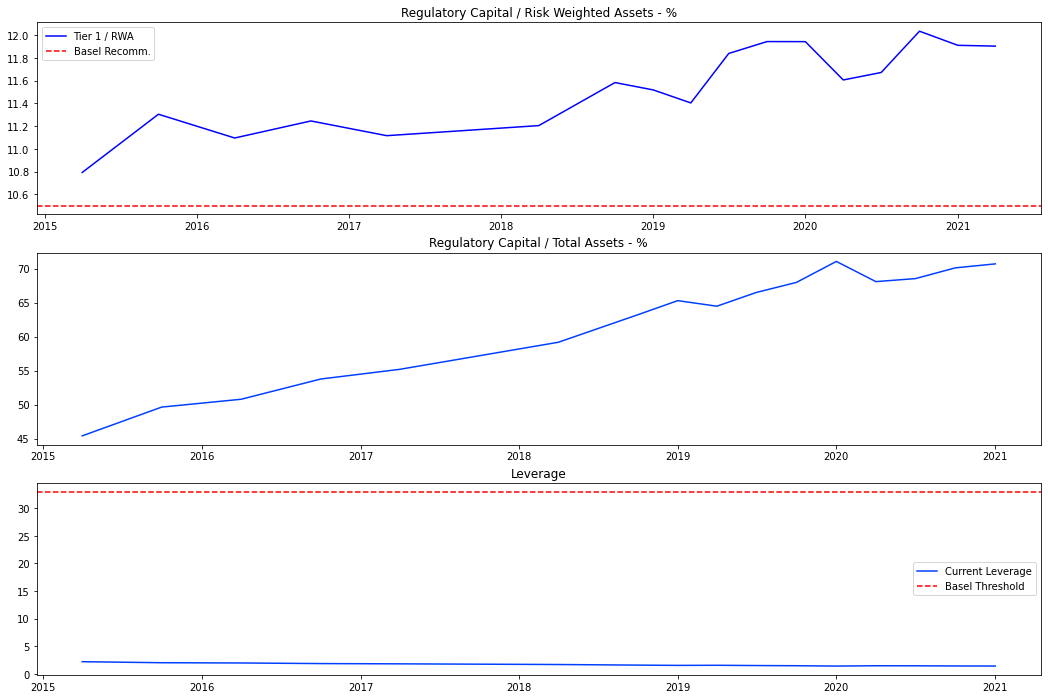

In [10]:
#Plot capital adequacy analysis
plt.figure(figsize=(18,12))
plt.subplot(311)
plt.plot(cap_adeq['Tier 1 / RWA'], color='blue')
plt.axhline(y=10.5, color='red', linestyle='--')
plt.title('Regulatory Capital / Risk Weighted Assets - %')
plt.legend(['Tier 1 / RWA', 'Basel Recomm.'])

plt.subplot(312)
plt.plot(cap_adeq['Tier 1 / Tot. Assets'])
plt.title('Regulatory Capital / Total Assets - %')

plt.subplot(313)
plt.plot(cap_adeq['Leverage'])
plt.axhline(y=33, color='red', linestyle='--')
plt.title('Leverage')
plt.legend(['Current Leverage', 'Basel Threshold'], loc='best')

plt.show()

In [11]:
#Asset quality
npl_to_tot = fetch_series('IMF/FSI/Q.CN.FSANL_PT')
npl_to_tot = clean_data(npl_to_tot, 'NPL / Total Loans - (Before Prov.)')

npl_net_to_capital = fetch_series('IMF/FSI/Q.CN.FSKNL_PT')
npl_net_to_capital = clean_data(npl_net_to_capital, 'NPL / Capital - (After Prov.)')

asset_quality = pd.concat([npl_to_tot, npl_net_to_capital], axis=1)
asset_quality.rename(columns={asset_quality.columns[0]: "NPL / Total Loans - (Before Prov.)", asset_quality.columns[1]: "NPL / Capital - (After Prov.)"}, inplace = True)
asset_quality.head()

NPL / Total Loans - (Before Prov.)  NPL / Capital - (After Prov.)
period                                                                       
2015-04-01                            1.499672                      -8.926557
2015-10-01                            1.673880                      -7.868429
2016-04-01                            1.746728                      -7.946680
2016-10-01                            1.744479                      -7.808932
2017-04-01                            1.743580                      -8.137138

<function matplotlib.pyplot.show(close=None, block=None)>

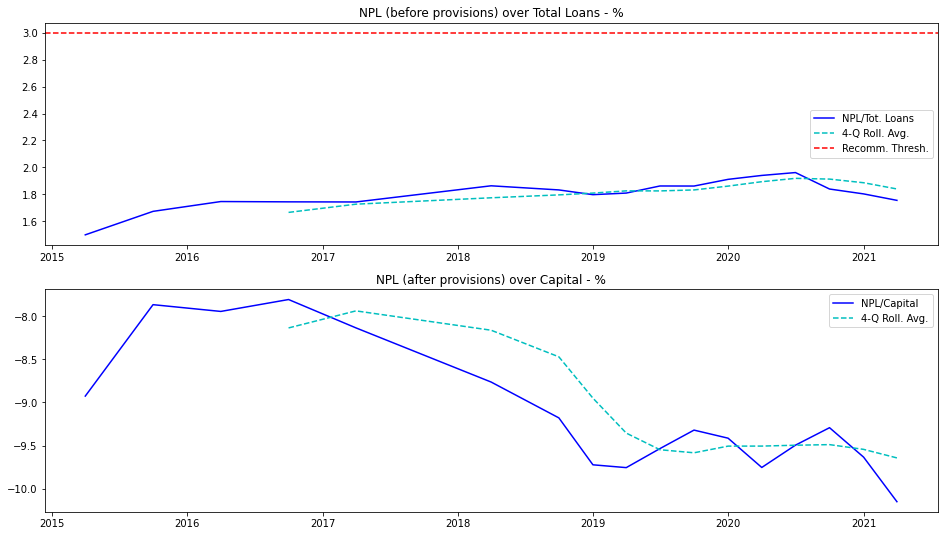

In [12]:
#Plot asset quality analysis
plt.figure(figsize=(16,9))
plt.subplot(211)
plt.plot(asset_quality['NPL / Total Loans - (Before Prov.)'], color='blue')
plt.plot(asset_quality['NPL / Total Loans - (Before Prov.)'].rolling(4).mean(), color='c', linestyle='--')
plt.axhline(y=3, color='red', linestyle='--')
plt.title('NPL (before provisions) over Total Loans - %')
plt.legend(['NPL/Tot. Loans', '4-Q Roll. Avg.', 'Recomm. Thresh.'])

plt.subplot(212)
plt.plot(asset_quality['NPL / Capital - (After Prov.)'], color='blue')
plt.plot(asset_quality['NPL / Capital - (After Prov.)'].rolling(4).mean(), color='c', linestyle='--')
plt.title('NPL (after provisions) over Capital - %')
plt.legend(['NPL/Capital', '4-Q Roll. Avg.'])

plt.show

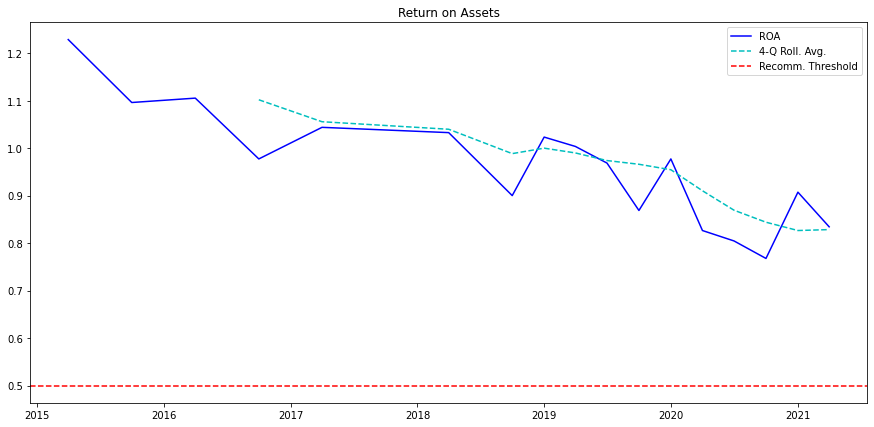

In [13]:
#Profitability analysis
roa = fetch_series('IMF/FSI/Q.CN.FSERA_PT')
roa = clean_data(roa, 'Return on Assets')

plt.figure(figsize=(15,7))
plt.plot(roa, color='blue')
plt.plot(roa.rolling(4).mean(), color='c', linestyle='--')
plt.axhline(y=0.5, color='red', linestyle='--')
plt.title('Return on Assets')
plt.legend(['ROA', '4-Q Roll. Avg.', 'Recomm. Threshold'])

plt.show()

In [14]:
#Liquidity analysis
liq_assets_to_sht_liab = fetch_series('IMF/FSI/Q.CN.FSLS_PT')
liq_assets_to_sht_liab = clean_data(liq_assets_to_sht_liab, 'Liquid Assets / Sht Liab.')

liq_asset_ratio = fetch_series('IMF/FSI/Q.CN.FSLT_PT')
liq_asset_ratio = clean_data(liq_asset_ratio, 'Liquid Asset Ratio')

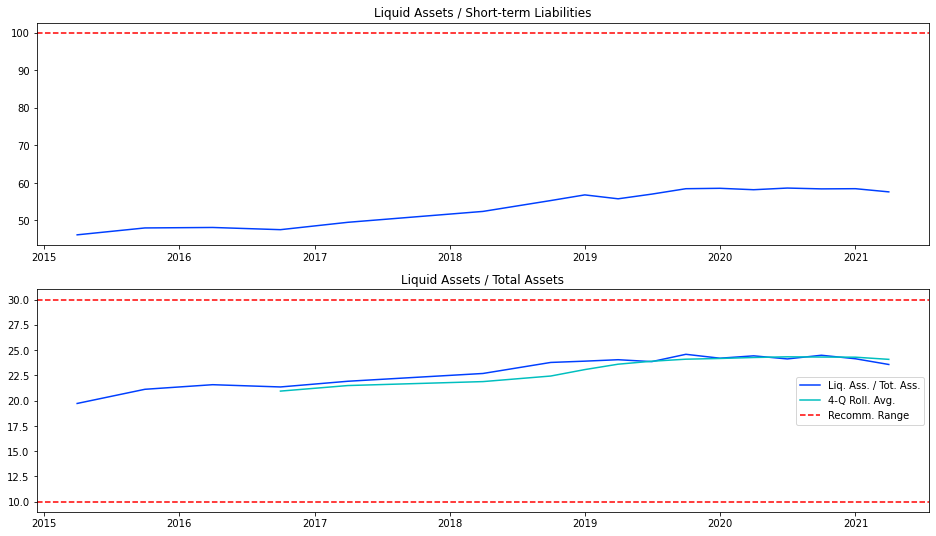

In [15]:
#Plot liquidity analysis
plt.figure(figsize=(16,9))
plt.subplot(211)
plt.plot(liq_assets_to_sht_liab)
plt.axhline(y=100, color='red', linestyle='--')
plt.title('Liquid Assets / Short-term Liabilities')

plt.subplot(212)
plt.plot(liq_asset_ratio)
plt.plot(liq_asset_ratio.rolling(4).mean(), color='c')
plt.axhline(y=10, color='red', linestyle='--')
plt.axhline(y=30, color='red', linestyle='--')
plt.title('Liquid Assets / Total Assets')
plt.legend(['Liq. Ass. / Tot. Ass.', '4-Q Roll. Avg.', 'Recomm. Range'])

plt.show()

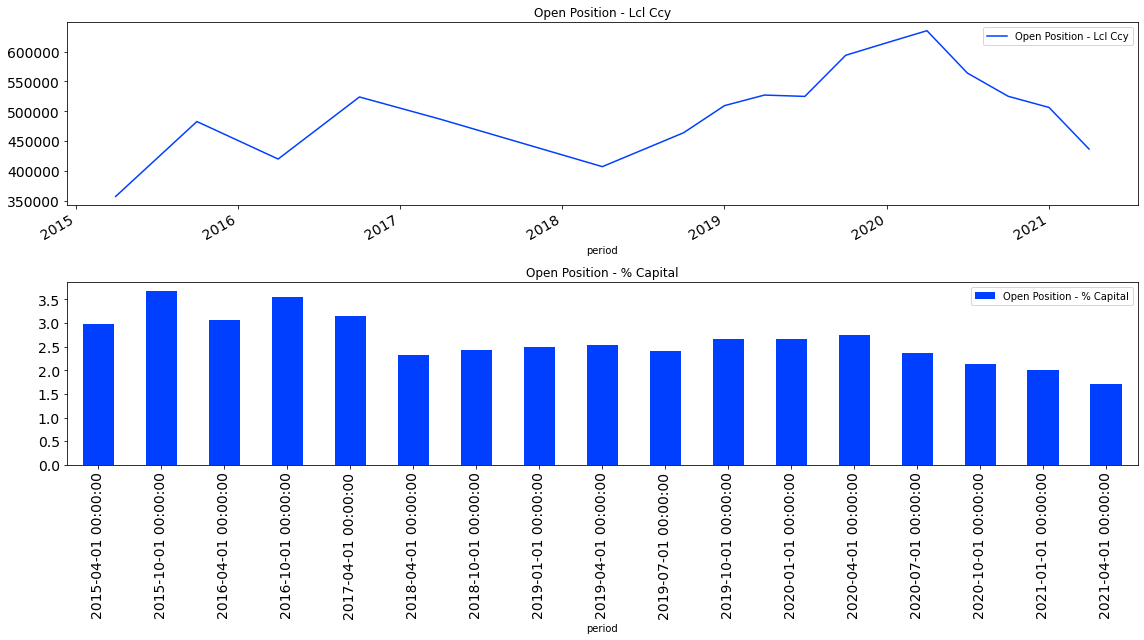

In [16]:
#Fetch Open Position data in absolute terms (national ccy) and relative to capital
op_lcl = fetch_series('IMF/FSI/Q.CN.FSNSNO_XDC')
op_lcl = clean_data(op_lcl, 'Open Position - Lcl Ccy')

op_to_capital = fetch_series('IMF/FSI/Q.CN.FSSNO_PT')
op_to_capital = clean_data(op_to_capital, 'Open Position - % Capital')

#Plot Open Position data for the country
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,9))


ax = op_lcl.plot(ax=axes[0], title='Open Position - Lcl Ccy', fontsize=14)

ax1 = op_to_capital.plot(ax=axes[1], kind='bar', stacked=False, title='Open Position - % Capital', fontsize=14)


fig.subplots_adjust(bottom=0.6)

fig.tight_layout()

plt.show()

Open Position is the difference between foreign assets and foreign liabilities. A negative figure means the country owes more than it can claims abroad, and if this negative value as a percentage of capital increases too much, that suggests that in case of a sharp depreciation of the currency, the country may struggle to honor its liabilities.

In [17]:
#Let's calculate the z-score
roa_std = (roa / 100).std()
z_score =  ((cap_adeq['Tier 1 / Tot. Assets'].iloc[-1] / 100)) + (roa.iloc[-1] /100 ) / roa_std

print('It takes about ' + (str(z_score.values)) + ' std(roa) to bankrupt the banks')

It takes about [nan] std(roa) to bankrupt the banks


In [18]:
p_value = scipy.stats.norm.sf(abs(z_score))
print('If ROA follows a normal distribution, probability of bank capital being exhausted is: ' + str(int(p_value)))

ValueError: cannot convert float NaN to integer

# Section 7: Fiscal Policy Analysis

In this section we look at how discretionary fiscal policy measures compare to the business cycle. Specifically, we want to understand if the fiscal policy is pro or counter-cyclical in relation to the business cycle. We will analyze the fiscal impulse (the first difference of the fiscal stance, that is a measure of fiscal policy net of automatic stabilizers) and the relative position of primary balance vs cyclically adjusted primiary balance to assess whether the economy is above or below potential.  

In [71]:
#Download data for overall and primary balance (in % of GDP)
overall_balance = fetch_series('IMF/FM/A.CN.GGXCNL_G01_GDP_PT')
overall_balance = clean_data(overall_balance, 'Overall Balance (% GDP)')

primary_balance = fetch_series('IMF/FM/A.CN.GGXONLB_G01_GDP_PT')
primary_balance = clean_data(primary_balance, 'Primary Balance (% GDP)')

cab = fetch_series('IMF/FM/A.CN.GGCB_G01_PGDP_PT')
cab = clean_data(cab, 'Cyclically Adjusted Balance (% Pot. GDP)')

capb = fetch_series('IMF/FM/A.CN.GGCBP_G01_PGDP_PT')
capb = clean_data(capb, 'Cyclically Adjusted Primary Balance (% Pot. GDP)')

str_bal = fetch_series('IMF/WEO:2021-04/CHN.GGSB_NPGDP.pcent_potential_gdp')
str_bal = clean_data(str_bal, 'Structural Balance (% Pot. GDP)')

fiscal_monitor = pd.concat([overall_balance, primary_balance, cab, capb, str_bal], axis=1)

fiscal_monitor['Interest Spending'] = fiscal_monitor['Primary Balance (% GDP)'] - fiscal_monitor['Overall Balance (% GDP)']

fiscal_monitor['Fiscal Stance'] = -capb

fiscal_monitor['Fiscal Impulse'] = fiscal_monitor['Fiscal Stance'] - fiscal_monitor['Fiscal Stance'].shift(1) 

fiscal_monitor = fiscal_monitor.dropna()

In [72]:
fiscal_monitor.tail()

Overall Balance (% GDP)  Primary Balance (% GDP)  \
period                                                         
2022-01-01                -6.831957                -5.894276   
2023-01-01                -6.181921                -5.212843   
2024-01-01                -5.611346                -4.620191   
2025-01-01                -4.978486                -3.968821   
2026-01-01                -4.511210                -3.485752   

            Cyclically Adjusted Balance (% Pot. GDP)  \
period                                                 
2022-01-01                                 -6.459262   
2023-01-01                                 -5.968347   
2024-01-01                                 -5.543633   
2025-01-01                                 -4.978486   
2026-01-01                                 -4.511210   

            Cyclically Adjusted Primary Balance (% Pot. GDP)  \
period                                                         
2022-01-01                                         -5.530490   
2023-01-01                                         -5.004696   
2024-01-01                                         -4.554262   
2025-01-01                                         -3.968821   
2026-01-01                                         -3.485752   

            Structural Balance (% Pot. GDP)  Interest Spending  Fiscal Stance  \
period                                                                          
2022-01-01                           -8.308           0.937680       5.530490   
2023-01-01                           -7.639           0.969078       5.004696   
2024-01-01                           -7.102           0.991155       4.554262   
2025-01-01                           -6.544           1.009666       3.968821   
2026-01-01                           -6.006           1.025458       3.485752   

            Fiscal Impulse  
period                      
2022-01-01       -0.511205  
2023-01-01       -0.525793  
2024-01-01       -0.450435  
2025-01-01       -0.585441  
2026-01-01       -0.483069

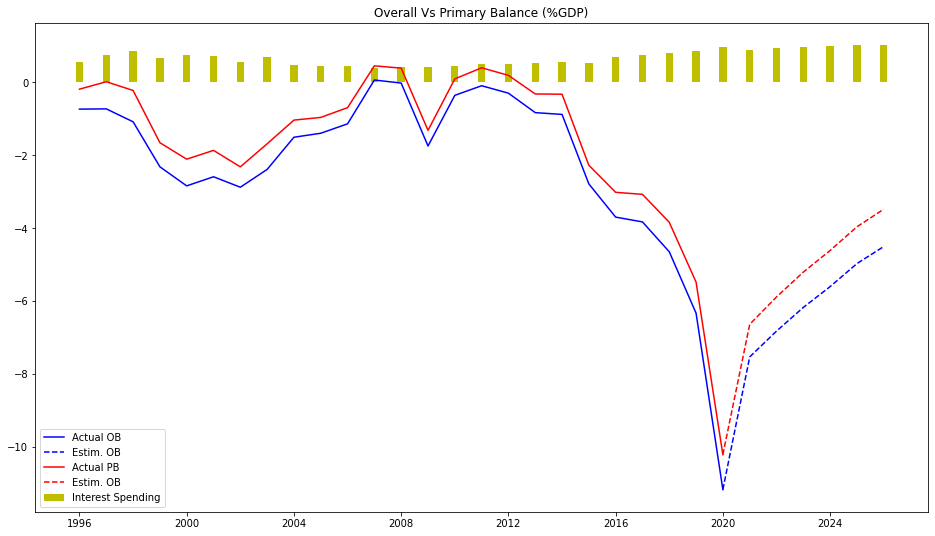

In [73]:
#Plot Overall vs Primary Balance and Interest Spending
plt.figure(figsize=(16,9))
plt.bar(fiscal_monitor.index, fiscal_monitor['Interest Spending'], width=100, color='y')
plt.plot(fiscal_monitor['Overall Balance (% GDP)'].loc[:today], color='blue')
plt.plot(fiscal_monitor['Overall Balance (% GDP)'].loc[today:], linestyle='--', color='blue')
plt.plot(fiscal_monitor['Primary Balance (% GDP)'].loc[:today], color='red')
plt.plot(fiscal_monitor['Primary Balance (% GDP)'].loc[today:], linestyle='--', color='red')
plt.title('Overall Vs Primary Balance (%GDP)')
plt.legend(['Actual OB', 'Estim. OB', 'Actual PB', 'Estim. OB', 'Interest Spending'])
plt.show()

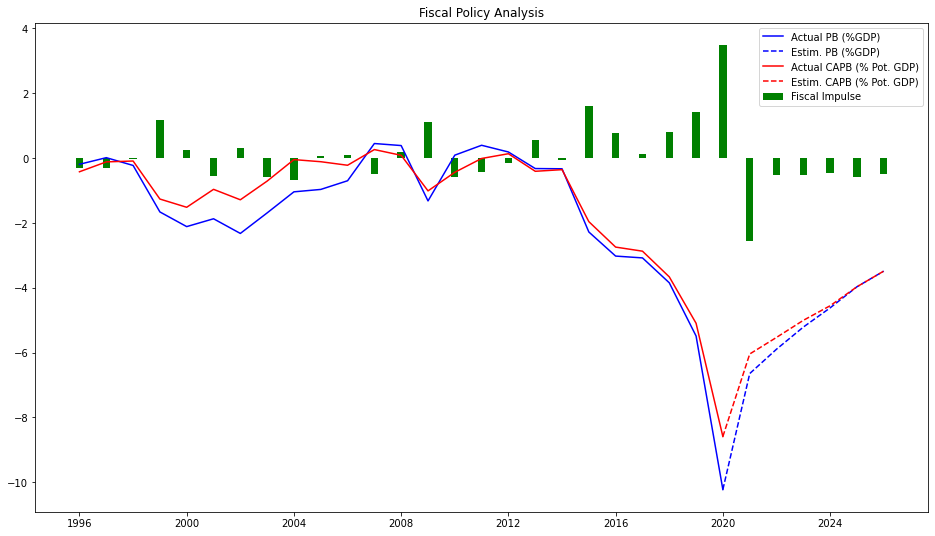

In [74]:
#Plot fiscal impulse to analyze if the fiscal policy is pro-cyclical or counter-cyclical
plt.figure(figsize=(16,9))
plt.bar(fiscal_monitor.index, fiscal_monitor['Fiscal Impulse'], width=100, color='g')
plt.plot(fiscal_monitor['Primary Balance (% GDP)'].loc[:today], color='blue')
plt.plot(fiscal_monitor['Primary Balance (% GDP)'].loc[today:], linestyle='--', color='blue')
plt.plot(fiscal_monitor['Cyclically Adjusted Primary Balance (% Pot. GDP)'].loc[:today], color='red')
plt.plot(fiscal_monitor['Cyclically Adjusted Primary Balance (% Pot. GDP)'].loc[today:], linestyle='--', color='red')
plt.title('Fiscal Policy Analysis')
plt.legend(['Actual PB (%GDP)', 'Estim. PB (%GDP)', 'Actual CAPB (% Pot. GDP)', 'Estim. CAPB (% Pot. GDP)','Fiscal Impulse'])
plt.show()

When Primary Balance > Cyclically Adjusted Primary Balance, output gap is positive: if fiscal impulse is positive, then fiscal policy is pro-cyclical, otherwise it is counter-cyclical. 

When Primary Balance < Cyclically Adjusted Primary Balance, output gap is negative: if fiscal impulse is negative, then fiscal policy is pro-cyclical, otherwise it is counter-cyclical.

Generally, we would like to see counter-cyclical fiscal policy to face short-term business cycle needs, but sometimes fiscal policy is pro-cyclical in order to balance medium-term fiscal policy sustainability.

# Section 8: Fiscal Sustainability Analysis

In this section we are going to look at how Debt to GDP varies according to different scenarios: in fact, changing hypothesis about gdp growth, interest rates, primary balance and currency depreciation/appreciation, we will obtain different paths of debt evolution.

In [75]:
#Fetch and plot Debt to GDP data
gross_debt_gdp = fetch_series('IMF/FM/A.CN.G_XWDG_G01_GDP_PT')
gross_debt_gdp = clean_data(gross_debt_gdp, 'Gross Debt to GDP')

In [76]:
gross_debt_gdp.tail(7)

Gross Debt to GDP
period                       
2020-01-01          66.333830
2021-01-01          68.945934
2022-01-01          72.059807
2023-01-01          74.476438
2024-01-01          76.603755
2025-01-01          78.451293
2026-01-01          80.144282

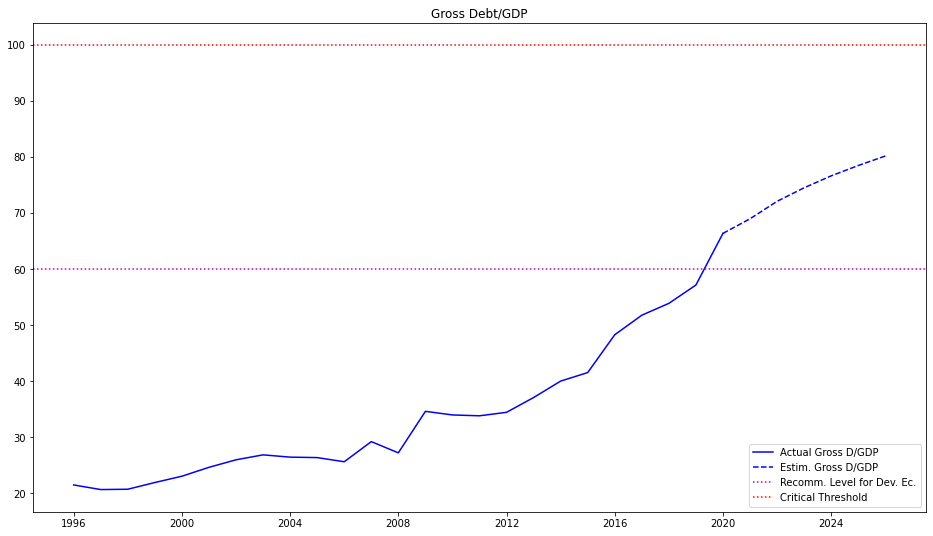

In [77]:
#Plot gross vs net Debt to GDP 
plt.figure(figsize=(16,9))
plt.plot(gross_debt_gdp.loc[:today], color='b')
plt.plot(gross_debt_gdp.loc[today:], linestyle='--', color='b')
plt.axhline(y=60, color='m', linestyle='dotted')
plt.axhline(y=100, color='red', linestyle='dotted')
plt.title('Gross Debt/GDP')
plt.legend(['Actual Gross D/GDP', 'Estim. Gross D/GDP', 'Recomm. Level for Dev. Ec.', 'Critical Threshold'])
plt.show()

In [78]:
#Let's define a function to calculate Public Debt to GDP
def fiscal_debt_path(gr1, gr2, gr3, gr4, gr5, r1, r2, r3, r4, r5, pb1, pb2, pb3, pb4, pb5):
    
    public_debt_t0 = gross_debt_gdp.loc[today]
    
    public_debt_t1 = (1 + r1) / (1 + gr1) * public_debt_t0 - pb1
    public_debt_t2 = (1 + r2) / (1 + gr2) * public_debt_t1 - pb2
    public_debt_t3 = (1 + r3) / (1 + gr3) * public_debt_t2 - pb3
    public_debt_t4 = (1 + r4) / (1 + gr4) * public_debt_t3 - pb4
    public_debt_t5 = (1 + r5) / (1 + gr5) * public_debt_t4 - pb5
    
    rng = pd.date_range(today, periods=6, freq='YS')
    scenario = pd.DataFrame()
    scenario = scenario.append([public_debt_t0, public_debt_t1, public_debt_t2, public_debt_t3, public_debt_t4, public_debt_t5])
    scenario = scenario.set_index(rng)
    
    plt.figure(figsize=(15,7))
    plt.plot(scenario, color='b', marker='s')
    plt.title('Public Debt to GDP - Scenario Analysis')


In [79]:
#Create a slider to make scenario analysis for Public Debt to GDP
widgets.interact(fiscal_debt_path, gr1=(-0.1, 0.1, 0.005), gr2=(-0.1, 0.1, 0.005), gr3=(-0.1, 0.1, 0.005), gr4=(-0.1, 0.1, 0.005), gr5=(-0.1, 0.1, 0.005), r1=(-0.1, 0.1, 0.005), r2=(-0.1, 0.1, 0.005), r3=(-0.1, 0.1, 0.005), r4=(-0.1, 0.1, 0.005), r5=(-0.1, 0.1, 0.005), pb1=(-15, 15, 1), pb2=(-15, 15, 1), pb3=(-15, 15, 1), pb4=(-15, 15, 1), pb5=(-15, 15, 1));

interactive(children=(FloatSlider(value=0.0, description='gr1', max=0.1, min=-0.1, step=0.005), FloatSlider(va…

# Section 9: External Position Analysis

In this section we will analyze the current account situation of the country. Specifically, we want to understand if the country is running a surplus or a deficit. The CA can be seen from two perspectives: net exports + primary and secondary income; or savings - investment. A deficit means the country is receivng more flows from abroad to finance its investment and have imports > exports; a surplus means that the country is investing more abroad to fund foreign countries investment and have exports > imports. We will also analyze the different components of the financial account. 

In [80]:
#Fetch quarterly CA data in USD and in %GDP
ca_usd_q = fetch_series('OECD/MEI/CHN.B6BLTT01.CXCUSA.Q')
ca_usd_q = clean_data(ca_usd_q, 'Current Account - Tot. Balance (USD)')

ca_gdp_q = fetch_series('OECD/MEI/CHN.B6BLTT02.STSA.Q')
ca_gdp_q = clean_data(ca_gdp_q, 'Current Account - Tot. Balance (%GDP)')

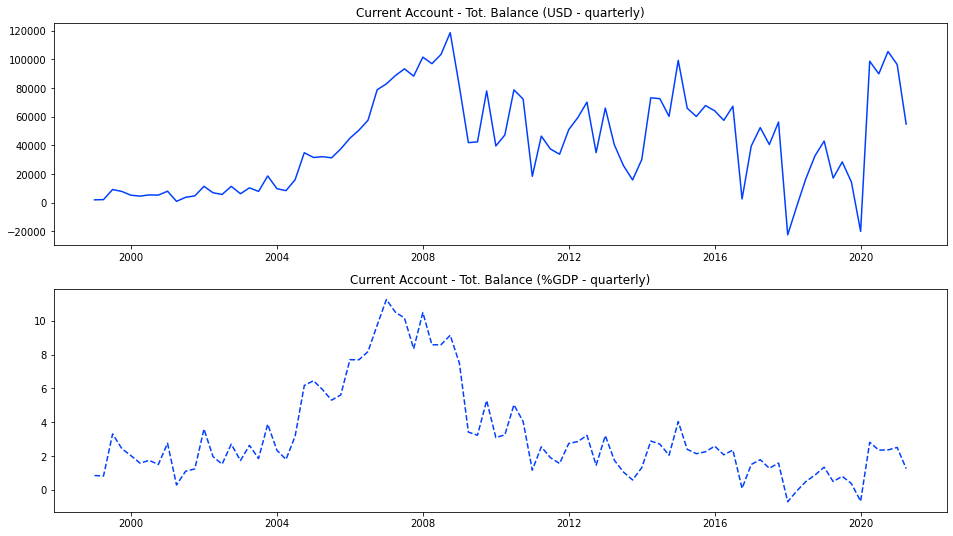

In [81]:
#Plot CA quarterly data
plt.subplots(figsize=(16,9))
plt.subplot(211)
plt.plot(ca_usd_q)
plt.title('Current Account - Tot. Balance (USD - quarterly)')

plt.subplot(212)
plt.plot(ca_gdp_q, linestyle='--')
plt.title('Current Account - Tot. Balance (%GDP - quarterly)')

plt.show()

In [82]:
#Fetch Current Account, Savings and Investments data (annual figures)
ca = fetch_series('IMF/WEO:2021-04/CHN.BCA_NGDPD.pcent_gdp')
ca = clean_data(ca, 'Current Account - %GDP')

savings = fetch_series('IMF/WEO:2021-04/CHN.NGSD_NGDP.pcent_gdp')
savings = clean_data(savings, 'Gross National Savings - %GDP')

investments = fetch_series('IMF/WEO:2021-04/CHN.NID_NGDP.pcent_gdp')
investments = clean_data(investments, 'Total Investments - %GDP')

ext_pos = pd.concat([ca, savings, investments], axis=1)

ext_pos.tail()

Current Account - %GDP  Gross National Savings - %GDP  \
period                                                              
2022-01-01                   1.323                         44.752   
2023-01-01                   1.141                         44.221   
2024-01-01                   0.917                         43.540   
2025-01-01                   0.713                         42.792   
2026-01-01                   0.534                         42.077   

            Total Investments - %GDP  
period                                
2022-01-01                    43.641  
2023-01-01                    43.356  
2024-01-01                    42.929  
2025-01-01                    42.464  
2026-01-01                    41.954

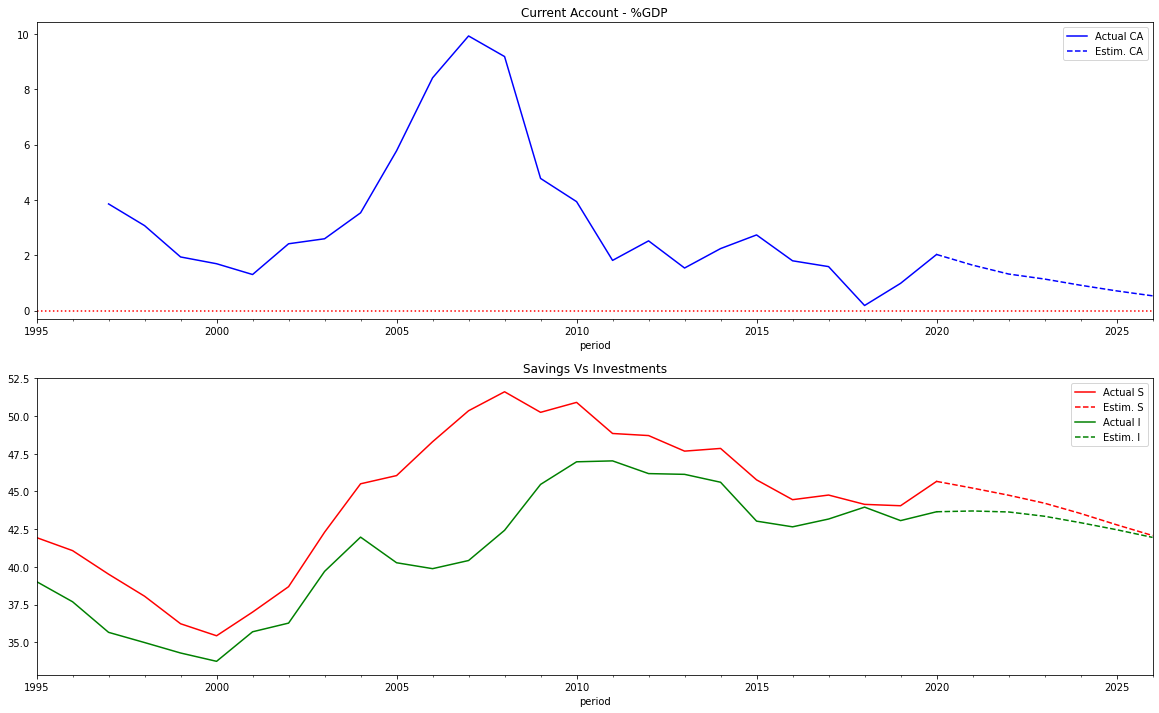

In [83]:
#Plot decomposition of CA
plt.figure(figsize=(20,12))

plt.subplot(211)
ext_pos['Current Account - %GDP'].loc[:today].plot(color='blue')
ext_pos['Current Account - %GDP'].loc[today:].plot(color='blue', linestyle='--')
plt.axhline(y=0, color='red', linestyle='dotted')
plt.title('Current Account - %GDP')
plt.legend(['Actual CA', 'Estim. CA'])

plt.subplot(212)
ext_pos['Gross National Savings - %GDP'].loc[:today].plot(color='red')
ext_pos['Gross National Savings - %GDP'].loc[today:].plot(color='red', linestyle='--')
ext_pos['Total Investments - %GDP'].loc[:today].plot(color='green')
ext_pos['Total Investments - %GDP'].loc[today:].plot(color='green', linestyle='--')
plt.title('Savings Vs Investments')
plt.legend(['Actual S', 'Estim. S', 'Actual I', 'Estim. I'])
plt.show()

If the country is running a current account deficit this means that our investment is being funded from abroad. From the financial perspective the country is accumulating liabilities. On the contrary, a current account surplus tells us that the country is providing savings to fund investment in other countries. From the financial perspective it is accumulating assets.

In [84]:
#Fetch quarterly data on Terms of Trade and Current account
tot = fetch_series('OECD/EO/CHN.TTRADE.A')
tot = clean_data(tot, 'Terms of Trade goods and services - A')


ca_ann = fetch_series('OECD/EO/CHN.CBGDPR.A')
ca_ann = clean_data(ca_ann, 'Current Account - A')

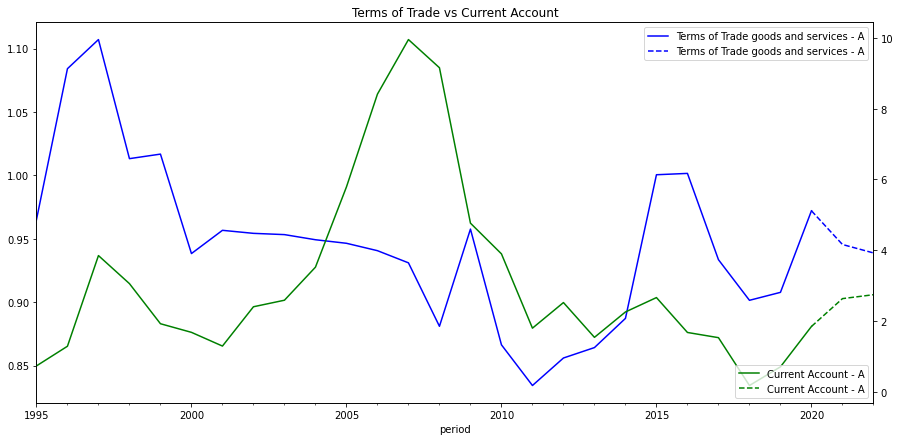

In [85]:
#Plot Terms of Trade and CA data
fig, ax = plt.subplots(figsize=(15,7))
tot.loc[:today].plot(ax=ax, color='b', legend=False)
tot.loc[today:].plot(ax=ax, color='b', linestyle='--', legend=False)
plt.legend(loc='lower left')
ca_ann.loc[:today].plot(ax=ax, color='g', legend=False, secondary_y=True)
ca_ann.loc[today:].plot(ax=ax, color='g', legend=False, secondary_y=True, linestyle='--')
plt.legend(loc='lower right')
plt.title('Terms of Trade vs Current Account')
plt.show()

External Terms of Trade (i.e. Price of exports / Price of imports) tell us how much did the changes in export prices or import prices, holding all else contant, boost or push down the CA balance

In [86]:
#Fetch REER data
reer = fetch_series('IMF/IFS/A.CN.EREER_IX')
reer = clean_data(reer, 'REER - A')

ca_ann = fetch_series('OECD/EO/CHN.CBGDPR.A')
ca_ann = clean_data(ca_ann, 'Current Account - A')

ca_vs_reer = pd.concat([reer, ca_ann], axis=1)
ca_vs_reer = ca_vs_reer.dropna()
ca_vs_reer.tail()

REER - A  Current Account - A
period                                     
2016-01-01  123.670004             1.683289
2017-01-01  120.093024             1.536758
2018-01-01  121.738816             0.186825
2019-01-01  120.888009             0.713879
2020-01-01  123.382166             1.852786

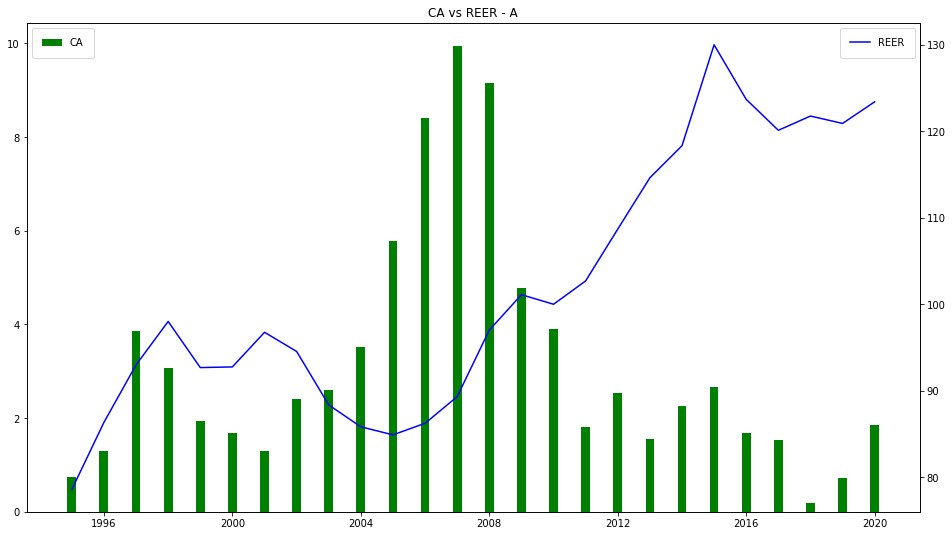

In [87]:
#Plot REER and CA data
fig, ax = plt.subplots(figsize=(16,9))
ax = plt.bar(ca_vs_reer.index, ca_vs_reer['Current Account - A'], width=100, color='g')
ax = plt.legend(['CA'], loc='upper left', borderpad=1)
plt.twinx()
ax1 = plt.plot(ca_vs_reer['REER - A'], color='b')
ax1 = plt.legend(['REER'], loc='upper right', borderpad=1)
plt.title('CA vs REER - A')

plt.show()

The Real Exchange Rate is inversely proportioned to the CA. In fact, an appreciation of the REER leads to an increasing CA deficit (because exports tend to decrease compared to imports if the currency appreciates); on the other hand, if the REER depreciates, we may expect a decreasing deficit or an increasing surplus (because exports tend to increase compared to imports if the currency depreciates). The elasticity of CA to variations in REER is given by eta (i.e. the CA elasticity).

In [88]:
#Let's fetch data on the financial account and organize them in a DataFrame
fa = ['IMF/BOPAGG/A.CN.BFD_BP6_USD', 
       'IMF/BOPAGG/A.CN.BFF_BP6_USD', 
       'IMF/BOPAGG/A.CN.BFOFR_BP6_USD', 
       'IMF/BOPAGG/A.CN.BFP_BP6_USD', 
       'IMF/BOPAGG/A.CN.BFRAFR_BP6_USD', 
       'IMF/BOPAGG/A.CN.BOPFR_BP6_USD']

fin_acc = pd.DataFrame()

for i in fa:
    fin_acc = fin_acc.append(fetch_series(i)[['period', 'series_name', 'value']])
    
fin_acc = fin_acc.pivot(index='period', columns='series_name', values='value')

ann_gdp_lcl = fetch_series('OECD/QNA/CHN.B1_GE.CQR.A')
ann_gdp_lcl = clean_data(ann_gdp_lcl, 'Annual GDP')

fx_ann = fetch_series('BIS/xru_current/A.CN.CNY.A')
fx_ann = clean_data(fx_ann, 'FX')

ann_gdp_usd = pd.DataFrame(index=ann_gdp_lcl.index)
ann_gdp_usd['GDP Local CCY'] = ann_gdp_lcl
ann_gdp_usd['FX'] = fx_ann
ann_gdp_usd['GDP USD'] = ann_gdp_usd['GDP Local CCY'] / ann_gdp_usd['FX']
ann_gdp_usd = ann_gdp_usd.dropna()


fin_acc['GDP'] = ann_gdp_usd['GDP USD']

fin_acc = fin_acc.dropna()
fin_acc.head()

series_name  Annual – China – Financial account, Financial derivatives (other than reserves) and employee stock options, US Dollars, Millions  \
period                                                                                                                                          
2015-01-01                                         2087.118580                                                                                  
2016-01-01                                         5384.031504                                                                                  
2017-01-01                                         -353.651987                                                                                  
2018-01-01                                         6153.444635                                                                                  
2019-01-01                                         2354.955675                                                                                  

series_name  Annual – China – Financial account, Net lending (+) / net borrowing (-) (balance from financial account), Direct investment, US Dollars, Millions  \
period                                                                                                                                                           
2015-01-01                                       -68098.649765                                                                                                   
2016-01-01                                        41674.876170                                                                                                   
2017-01-01                                       -27790.987920                                                                                                   
2018-01-01                                       -92338.473352                                                                                                   
2019-01-01                                       -58111.900840                                                                                                   

series_name  Annual – China – Financial account, Portfolio investment, US Dollars, Millions  \
period                                                                                        
2015-01-01                                        66470.061883                                
2016-01-01                                        52270.616754                                
2017-01-01                                       -29497.793098                                
2018-01-01                                      -106873.525547                                
2019-01-01                                       -57947.645386                                

series_name  Annual – China – Supplementary Items, Errors and Omissions (with Fund Record), US Dollars, Millions  \
period                                                                                                             
2015-01-01                                      -212959.391077                                                     
2016-01-01                                      -229413.770079                                                     
2017-01-01                                      -213035.847932                                                     
2018-01-01                                      -178736.216606                                                     
2019-01-01                                      -198050.929761                                                     

series_name  Annual – China – Supplementary Items, Other Investment Net (with Fund Record), US Dollars, Millions  \
period                                                                                                             
2015-01-01                                       434003.615868                                                     
2016-01-01            

In [89]:
#Let's calculate each item of the financial account as a % of GDP
fin_acc_to_gdp = fin_acc.iloc[:,:-1].div(fin_acc.GDP, axis=0)
fin_acc_to_gdp.head()

series_name  Annual – China – Financial account, Financial derivatives (other than reserves) and employee stock options, US Dollars, Millions  \
period                                                                                                                                          
2015-01-01                                            0.000190                                                                                  
2016-01-01                                            0.000479                                                                                  
2017-01-01                                           -0.000029                                                                                  
2018-01-01                                            0.000443                                                                                  
2019-01-01                                            0.000165                                                                                  

series_name  Annual – China – Financial account, Net lending (+) / net borrowing (-) (balance from financial account), Direct investment, US Dollars, Millions  \
period                                                                                                                                                           
2015-01-01                                           -0.006214                                                                                                   
2016-01-01                                            0.003710                                                                                                   
2017-01-01                                           -0.002257                                                                                                   
2018-01-01                                           -0.006648                                                                                                   
2019-01-01                                           -0.004071                                                                                                   

series_name  Annual – China – Financial account, Portfolio investment, US Dollars, Millions  \
period                                                                                        
2015-01-01                                            0.006065                                
2016-01-01                                            0.004653                                
2017-01-01                                           -0.002396                                
2018-01-01                                           -0.007695                                
2019-01-01                                           -0.004060                                

series_name  Annual – China – Supplementary Items, Errors and Omissions (with Fund Record), US Dollars, Millions  \
period                                                                                                             
2015-01-01                                           -0.019431                                                     
2016-01-01                                           -0.020422                                                     
2017-01-01                                           -0.017305                                                     
2018-01-01                                           -0.012869                                                     
2019-01-01                                           -0.013875                                                     

series_name  Annual – China – Supplementary Items, Other Investment Net (with Fund Record), US Dollars, Millions  \
period                                                                                                             
2015-01-01                                            0.039600                                                     
2016-01-01            

In [90]:
fin_acc_to_gdp = fin_acc_to_gdp * 100
fin_acc_to_gdp.head()

series_name  Annual – China – Financial account, Financial derivatives (other than reserves) and employee stock options, US Dollars, Millions  \
period                                                                                                                                          
2015-01-01                                            0.019044                                                                                  
2016-01-01                                            0.047929                                                                                  
2017-01-01                                           -0.002873                                                                                  
2018-01-01                                            0.044304                                                                                  
2019-01-01                                            0.016498                                                                                  

series_name  Annual – China – Financial account, Net lending (+) / net borrowing (-) (balance from financial account), Direct investment, US Dollars, Millions  \
period                                                                                                                                                           
2015-01-01                                           -0.621357                                                                                                   
2016-01-01                                            0.370990                                                                                                   
2017-01-01                                           -0.225749                                                                                                   
2018-01-01                                           -0.664824                                                                                                   
2019-01-01                                           -0.407124                                                                                                   

series_name  Annual – China – Financial account, Portfolio investment, US Dollars, Millions  \
period                                                                                        
2015-01-01                                            0.606497                                
2016-01-01                                            0.465313                                
2017-01-01                                           -0.239613                                
2018-01-01                                           -0.769475                                
2019-01-01                                           -0.405973                                

series_name  Annual – China – Supplementary Items, Errors and Omissions (with Fund Record), US Dollars, Millions  \
period                                                                                                             
2015-01-01                                           -1.943119                                                     
2016-01-01                                           -2.042243                                                     
2017-01-01                                           -1.730509                                                     
2018-01-01                                           -1.286876                                                     
2019-01-01                                           -1.387516                                                     

series_name  Annual – China – Supplementary Items, Other Investment Net (with Fund Record), US Dollars, Millions  \
period                                                                                                             
2015-01-01                                            3.960008                                                     
2016-01-01            

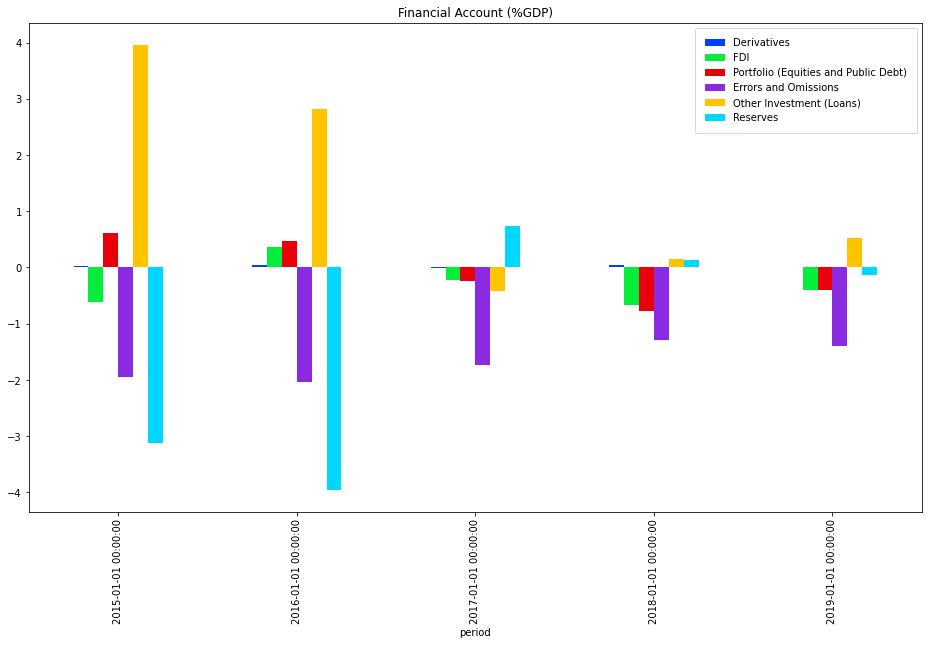

In [91]:
#Plot financial account components evolution
fin_acc_to_gdp.iloc[-5:].plot(kind='bar', figsize=(16,9))
plt.legend(['Derivatives', 'FDI', 'Portfolio (Equities and Public Debt)', 'Errors and Omissions', 'Other Investment (Loans)', 'Reserves'], loc='upper right', borderpad=1)
plt.title('Financial Account (%GDP)')
plt.show()

The Financial Account has to be interpreted as: if CA > 0, then FA > 0; if CA < 0, then FA > 0. In fact, the financial account is the way current account is financed. Therefore, a negative change in FDI/Portfolio/Derivatives/Other Investment means that the country is accumulating more liabilities (i.e. inward flows > outward flows); on the contrary, if reserves are decreasing, the country is financing temporary shocks to the CA with its stock of reserves. 

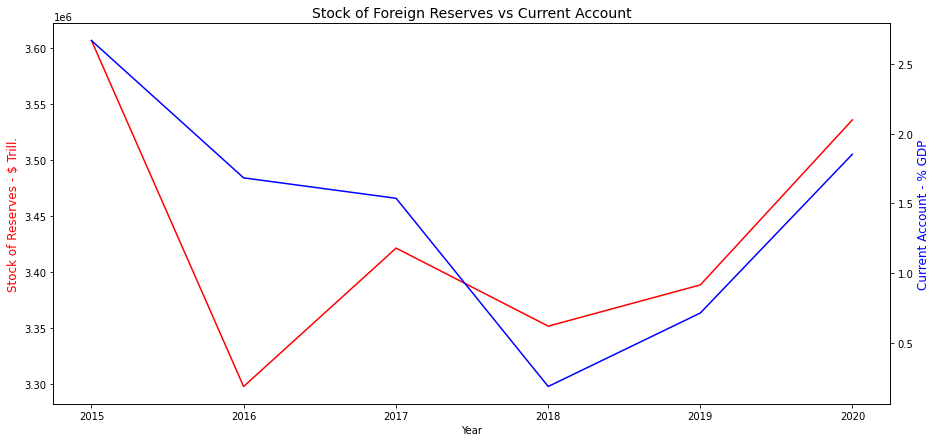

In [92]:
#Download stock of foreign reserves data
fx_reserves = fetch_series('IMF/IRFCL/A.CN.RAF_USD.S1X')
fx_reserves = clean_data(fx_reserves, 'Stock of Foreign Reserves - A')
fx_reserves['CA'] = ca_ann
fx_reserves = fx_reserves.dropna()

#Plot stock of foreign reserves data
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(fx_reserves.index, fx_reserves['Stock of Foreign Reserves - A'], color='r')
ax.set_xlabel('Year')
ax.set_ylabel('Stock of Reserves - $ Trill.', fontsize=12, color='r')
ax2 = ax.twinx()
ax2.plot(fx_reserves.index, fx_reserves['CA'], color='b')
ax2.set_ylabel('Current Account - % GDP', fontsize=12, color='b')

plt.title('Stock of Foreign Reserves vs Current Account', fontsize=14)
plt.show()

# Section 10: Real Exchange Rate and Competitiveness

In this section we are looking at how the current account and REER are positioned relative to their equilibrium levels. Specifically, with the help of the IMF External Balance Assessment framework, we will see if the country is running a positive current account gap (i.e., Actual CA > Norm CA) or a negative current account gap (i.e., Actual CA < Norm CA). In the former case, the REER is relatively undervalued and it has to appreciate to bring the CA balance back to its equilibrium level (in this scenario, exports are more stimulated than imports); in the latter case, REER is to be considered overvalued and it has to depreciate to bring the CA balance back to its equilibrium level (in this scenario, imports are more stimulated than exports).

There are several methods used by IMF to assess the current account gap and REER gap compared to their equilibrium level (i.e., EBA CA Regression, External Sustainability approach, EBA REER Regression). Since data for these estimates cannot be downloaded from public datasets and that calculations are not easy to implement, we will only report lates data from the IMF EBA website and compared them with significant thresholds.

https://www.imf.org/external/np/res/eba/data.htm

In [93]:
#CURRENT ACCOUNT REGRESSION-BASED ANALYSIS
period = [2014, 2015, 2016, 2017, 2018, 2019]

reg_ca_gap = [2.5, 2.3, 1.5, 1.7, 0.8, 1.2]

In [94]:
#EXTERNAL SUSTAINABILITY ANALYSIS
es_ca_gap = [2.9, -0.8, -0.5, -1.2, -1.7, -0.4]

In [95]:
#REER REGRESSION-BASED ANALYSIS: INDEX REER
index_reer_gap = [-6.5, 4.1, -2.7, -5.3, 0.0, -1.1]

In [96]:
#REER REGRESSION-BASED ANALYSIS: LEVEL REER
level_reer_gap = [6.8, 16.5, 6.3, 8.0, 12.6, 11.4]

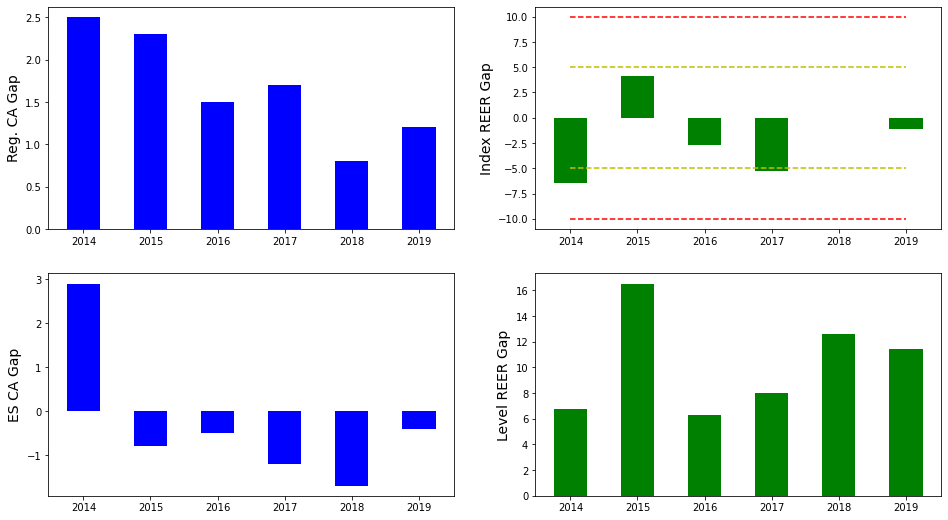

In [97]:
#Plot CA and REER gap according to EBA framework
fig, axs = plt.subplots(2, 2, figsize=(16, 9))
axs[0,0].bar(period, reg_ca_gap, width=0.5, color='b')
axs[0,0].set_ylabel('Reg. CA Gap', fontsize=14)
axs[1,0].bar(period, es_ca_gap, width=0.5, color='b')
axs[1,0].set_ylabel('ES CA Gap', fontsize=14)
axs[0,1].bar(period, index_reer_gap, width=0.5, color='g')
axs[0,1].plot([period[0], period[-1]], [5,5], color='y', linestyle='--')
axs[0,1].plot([period[0], period[-1]], [10,10], color='r', linestyle='--')
axs[0,1].plot([period[0], period[-1]], [-5,-5], color='y', linestyle='--')
axs[0,1].plot([period[0], period[-1]], [-10,-10], color='r', linestyle='--')
axs[0,1].set_ylabel('Index REER Gap', fontsize=14)
axs[1,1].bar(period, level_reer_gap, width=0.5, color='g')
axs[1,1].set_ylabel('Level REER Gap', fontsize=14)

plt.show()

According to the IMF framework, if the value of the REER gap is between -5% and 5%, then the REER is broadly in line with fundamentals. If it is between -5% and -10% or between 5% and 10%, then it is moderately misaligned. 

# Section 11: External Vulnerability

In this section we are going to assess the adequacy of reserves held by the central bank to face possible future external shocks, either from the trade side (e.g., a sharp decline in the terms of trade for the depreciation of a key commodity exported by the country) or from the financial account (e.g., tightening monetary conditions abroad). The CB will have to shield the economy selling its reserves to avoid a currency depreciation, but this intervention should be taken in response to a temporary, not permanent, shock. Otherwise, the CB will run out of reserves and be subject to speculators' attacks.

In [98]:
#Let's retrieve specific data for the ARA analysis and organize them in a DataFrame
exp_gs_usd = fetch_series('UNCTAD/GASBEAIOGASA/A.exports.us-dollars-at-current-prices-in-millions.total-trade-in-goods-and-services.china')
exp_gs_usd = clean_data(exp_gs_usd, 'Exports G&S - USD Mill.')
exp_gs_usd['Exports G&S - USD Bill.'] = exp_gs_usd['Exports G&S - USD Mill.'] / 1000

sht_debt = fetch_series('WB/WDI/DT.DOD.DSTC.CD-CN')
sht_debt = clean_data(sht_debt, 'Ext. Sht Debt - USD')
sht_debt['Ext. Sht Debt - USD Bill.'] = sht_debt['Ext. Sht Debt - USD'] / 1000000000

oth_liab = fetch_series('SAFE/CIIP/L4.A.USD')
oth_liab = clean_data(oth_liab, 'Other Liab. - USD 100 Mill.')
oth_liab['Other Liab. - USD Bill.'] = oth_liab['Other Liab. - USD 100 Mill.'] / 10

m3 = fetch_series('OECD/MEI/CHN.MABMM301.STSA.A')
m3 = clean_data(m3, 'M3 - CNY Bill.')
m3['fx'] = fx_ann
m3['M3 - USD Bill.'] = m3['M3 - CNY Bill.'] / m3['fx']

fx_res = fx_reserves['Stock of Foreign Reserves - A'] / 1000

var_df = pd.concat([exp_gs_usd['Exports G&S - USD Bill.'], sht_debt['Ext. Sht Debt - USD Bill.'], oth_liab['Other Liab. - USD Bill.'], m3['M3 - USD Bill.']], axis=1)
var_df = var_df.dropna()
var_df.tail()


Exports G&S - USD Bill.  Ext. Sht Debt - USD Bill.  \
period                                                           
2015-01-01              2361.387994                 822.244080   
2016-01-01              2199.047796                 801.396078   
2017-01-01              2444.304293                1030.633085   
2018-01-01              2688.893838                1218.901082   
2019-01-01              2669.832179                1205.312081   

            Other Liab. - USD Bill.  M3 - USD Bill.  
period                                               
2015-01-01               964.308616    22151.007558  
2016-01-01               984.445606    23328.869453  
2017-01-01              1219.661914    24809.028241  
2018-01-01              1329.397551    27599.752640  
2019-01-01              1291.329058    28742.279223

In [99]:
#Lets' multiply 
percentages = [0.05, 0.3, 0.15, 0.05]
ara = var_df.mul(percentages)
ara['Recomm. Reserves - USD Bill.'] = ara.sum(axis=1)
ara['Reserves - USD Bill.'] = fx_res
ara['ARA'] = (ara['Reserves - USD Bill.'] / ara['Recomm. Reserves - USD Bill.']) * 100
ara = ara.dropna()
ara.tail()

Exports G&S - USD Bill.  Ext. Sht Debt - USD Bill.  \
period                                                           
2015-01-01               118.069400                 246.673224   
2016-01-01               109.952390                 240.418823   
2017-01-01               122.215215                 309.189926   
2018-01-01               134.444692                 365.670325   
2019-01-01               133.491609                 361.593624   

            Other Liab. - USD Bill.  M3 - USD Bill.  \
period                                                
2015-01-01               144.646292     1107.550378   
2016-01-01               147.666841     1166.443473   
2017-01-01               182.949287     1240.451412   
2018-01-01               199.409633     1379.987632   
2019-01-01               193.699359     1437.113961   

            Recomm. Reserves - USD Bill.  Reserves - USD Bill.         ARA  
period                                                                      
2015-01-01                   1616.939294              3606.788  223.062672  
2016-01-01                   1664.481527              3298.047  198.142602  
2017-01-01                   1854.805839              3421.567  184.470360  
2018-01-01                   2079.512281              3351.916  161.187603  
2019-01-01                   2125.898553              3388.699  159.400786

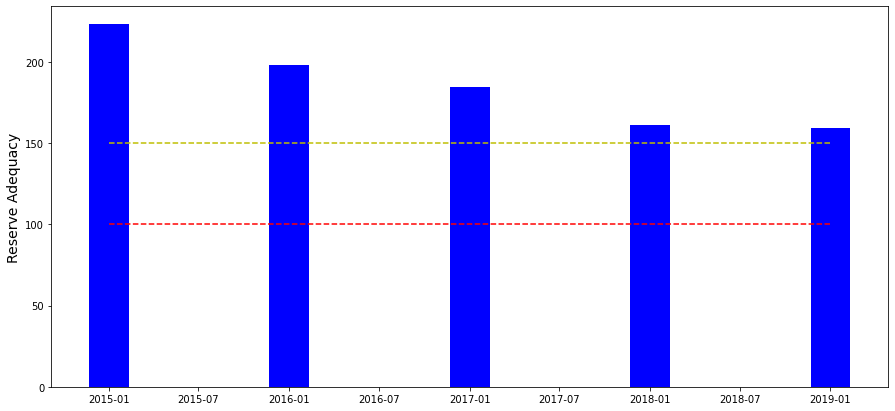

In [100]:
#Plot ARA results
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.bar(ara.index, ara['ARA'], width= 80, color='b')
ax.plot([ara.index[0], ara.index[-1]], [100,100], color='r', linestyle='--')
ax.plot([ara.index[0], ara.index[-1]], [150,150], color='y', linestyle='--')
ax.set_ylabel('Reserve Adequacy', fontsize=14)
plt.show()

According to the IMF ARA framework, countries should held at least 100% of the recommended reserves obtained as the sum of fractions of key trading and financial variables (i.e. exports of g&s, short-term debt, other liabilities and M3).

# Section 12: Trading Partners Analysis

In this section we will assess economic health status of main trading partners of the country to determine if there is an external threat to growth. 

In [101]:
#URL with the table containing the list of main trading partners
url="https://en.wikipedia.org/wiki/List_of_the_largest_trading_partners_of_China"

# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text

# Parse the html content
soup = BeautifulSoup(html_content, "lxml")

In [102]:
#Let’s just first print the title of the webpage
print(soup.title.text)

List of the largest trading partners of China - Wikipedia


In [103]:
#Put data from Wikipedia into a DataFrame
tp_table = soup.find("table", attrs={"class": "wikitable"})
tp_data = pd.read_html(str(tp_table))
tp_data = pd.DataFrame(tp_data[0])
tp_data = tp_data.drop(['Exports', 'Imports'], axis=1)
tp_data.head(13)

Rank Country / Territory  Total trade  Tradebalance
0     1       United States        583.3         275.8
1     2      European Union        573.0         177.1
2     -               ASEAN        514.3          41.5
3     3               Japan        303.0         -28.6
4     4           Hong Kong        286.5         206.1
5     5         South Korea        280.2         -74.8
6     6              Taiwan        199.9        -112.0
7     7           Australia        136.4         -53.6
8     8             Vietnam        121.9          21.3
9     9            Malaysia         96.1         -12.7
10   10              Brazil         87.0         -29.9
11   11               India         84.3          52.0
12   12              Russia         84.2           1.5

In [104]:
#Let's create a list with top trading partners GDP growth forecasts
tp_list = ['IMF/WEOAGG:2021-04/998.NGDP_RPCH.pcent_change', 
          'IMF/WEO:2021-04/AUS.NGDP_RPCH.pcent_change', 
          'IMF/WEO:2021-04/BRA.NGDP_RPCH.pcent_change', 
          'IMF/WEO:2021-04/HKG.NGDP_RPCH.pcent_change', 
          'IMF/WEO:2021-04/JPN.NGDP_RPCH.pcent_change',
          'IMF/WEO:2021-04/KOR.NGDP_RPCH.pcent_change', 
          'IMF/WEO:2021-04/MYS.NGDP_RPCH.pcent_change', 
          'IMF/WEO:2021-04/TWN.NGDP_RPCH.pcent_change', 
          'IMF/WEO:2021-04/USA.NGDP_RPCH.pcent_change', 
          'IMF/WEO:2021-04/VNM.NGDP_RPCH.pcent_change']

#Fetch data of annual GDP grwoth for main trading partners and store them in a DataFrame
trad_part = pd.DataFrame()

for i in tp_list:
    trad_part = trad_part.append(fetch_series(i)[['period', 'series_name', 'value']])
    
trad_part = trad_part.pivot(index='period', columns='series_name', values='value')

trad_part.tail()

series_name  Australia – Gross domestic product, constant prices (NGDP_RPCH) – Percent change  \
period                                                                                          
2022-01-01                                               2.752                                  
2023-01-01                                               2.276                                  
2024-01-01                                               2.305                                  
2025-01-01                                               2.377                                  
2026-01-01                                               2.461                                  

series_name  Brazil – Gross domestic product, constant prices (NGDP_RPCH) – Percent change  \
period                                                                                       
2022-01-01                                               2.565                               
2023-01-01                                               2.141                               
2024-01-01                                               2.015                               
2025-01-01                                               2.015                               
2026-01-01                                               2.015                               

series_name  European Union – Gross domestic product, constant prices (NGDP_RPCH) – Percent change  \
period                                                                                               
2022-01-01                                               3.938                                       
2023-01-01                                               2.271                                       
2024-01-01                                               1.907                                       
2025-01-01                                               1.646                                       
2026-01-01                                               1.569                                       

series_name  Hong Kong SAR – Gross domestic product, constant prices (NGDP_RPCH) – Percent change  \
period                                                                                              
2022-01-01                                               3.822                                      
2023-01-01                                               2.832                                      
2024-01-01                                               2.770                                      
2025-01-01                                               2.888                                      
2026-01-01                                               2.934                                      

series_name  Japan – Gross domestic product, constant prices (NGDP_RPCH) – Percent change  \
period                                                                                      
2022-01-01                                               2.525                              
2023-01-01                                               1.138                              
2024-01-01                                               0.689                              
2025-01-01                                               0.567                              
2026-01-01                                               0.492                              

series_name  Korea – Gross domestic product, constant prices (NGDP_RPCH) – Percent change  \
period                                                                                      
2022-01-01                                               2.803                              
2023-01-01                                               2.551                              
2024-01-01                                               2.371                              
2025-01-01                                               2.287                              
2026-01-01                  

In [105]:
#Let's rename the columns
col_names = ['Australia', 'Brazil', 'EU', 'Hong Kong', 'Japan', 'Korea', 'Malaysia', 'Taiwan', 'USA', 'Vietnam']
trad_part.columns = col_names
trad_part = trad_part.iloc[-6:]
trad_part.tail(6)

Australia  Brazil     EU  Hong Kong  Japan  Korea  Malaysia  \
period                                                                    
2021-01-01      4.538   3.655  4.364      4.289  3.252  3.585       6.5   
2022-01-01      2.752   2.565  3.938      3.822  2.525  2.803       6.0   
2023-01-01      2.276   2.141  2.271      2.832  1.138  2.551       5.7   
2024-01-01      2.305   2.015  1.907      2.770  0.689  2.371       5.3   
2025-01-01      2.377   2.015  1.646      2.888  0.567  2.287       5.0   
2026-01-01      2.461   2.015  1.569      2.934  0.492  2.287       5.0   

            Taiwan    USA  Vietnam  
period                              
2021-01-01   4.748  6.386    6.500  
2022-01-01   3.043  3.515    7.200  
2023-01-01   2.504  1.410    6.950  
2024-01-01   2.286  1.481    6.821  
2025-01-01   2.049  1.607    6.630  
2026-01-01   2.051  1.610    6.610

In [106]:
#Let's create a list with top trading partners imports (in USD) forecasts
tp_imp_list = ['IMF/WEO:2021-04/AUS.TMG_RPCH.pcent_change', 
              'IMF/WEO:2021-04/BRA.TMG_RPCH.pcent_change', 
              'IMF/WEO:2021-04/HKG.TMG_RPCH.pcent_change', 
              'IMF/WEO:2021-04/JPN.TMG_RPCH.pcent_change', 
              'IMF/WEO:2021-04/KOR.TMG_RPCH.pcent_change', 
              'IMF/WEO:2021-04/MYS.TMG_RPCH.pcent_change', 
              'IMF/WEO:2021-04/TWN.TMG_RPCH.pcent_change', 
              'IMF/WEO:2021-04/USA.TMG_RPCH.pcent_change', 
              'IMF/WEO:2021-04/VNM.TMG_RPCH.pcent_change', 
              'IMF/WEO:2021-04/DEU.TMG_RPCH.pcent_change']

#Fetch data of annual GDP grwoth for main trading partners and store them in a DataFrame
trad_part_imp = pd.DataFrame()

for i in tp_imp_list:
    trad_part_imp = trad_part_imp.append(fetch_series(i)[['period', 'series_name', 'value']])
    
trad_part_imp = trad_part_imp.pivot(index='period', columns='series_name', values='value')

trad_part_imp.tail()

series_name  Australia – Volume of Imports of goods – Percent change  \
period                                                                 
2022-01-01                                               3.353         
2023-01-01                                               3.058         
2024-01-01                                               2.574         
2025-01-01                                               2.625         
2026-01-01                                               2.422         

series_name  Brazil – Volume of Imports of goods – Percent change  \
period                                                              
2022-01-01                                                 1.0      
2023-01-01                                                 3.0      
2024-01-01                                                 3.0      
2025-01-01                                                 3.0      
2026-01-01                                                 3.0      

series_name  Germany – Volume of Imports of goods – Percent change  \
period                                                               
2022-01-01                                               7.821       
2023-01-01                                               3.988       
2024-01-01                                               3.803       
2025-01-01                                               3.443       
2026-01-01                                               3.389       

series_name  Hong Kong SAR – Volume of Imports of goods – Percent change  \
period                                                                     
2022-01-01                                               4.589             
2023-01-01                                               3.634             
2024-01-01                                               3.628             
2025-01-01                                               3.686             
2026-01-01                                               3.662             

series_name  Japan – Volume of Imports of goods – Percent change  \
period                                                             
2022-01-01                                               8.687     
2023-01-01                                               2.391     
2024-01-01                                               2.289     
2025-01-01                                               2.105     
2026-01-01                                               2.092     

series_name  Korea – Volume of Imports of goods – Percent change  \
period                                                             
2022-01-01                                               4.401     
2023-01-01                                               3.802     
2024-01-01                                               3.608     
2025-01-01                                               3.327     
2026-01-01                                               3.127     

series_name  Malaysia – Volume of Imports of goods – Percent change  \
period                                                                
2022-01-01                                               4.682        
2023-01-01                                               5.501        
2024-01-01                                               5.305        
2025-01-01                                               4.351        
2026-01-01                                               4.415        

series_name  Taiwan Province of China – Volume of Imports of goods – Percent change  \
period                                                                                
2022-01-01                                               4.640                        
2023-01-01                                               2.662                        
2024-01-01                                               2.167                        
2025-01-01                                               2.102                        
2026-01-01   

In [107]:
#Let's rename the columns
trad_part_imp.columns = col_names
trad_part_imp = trad_part_imp.iloc[-6:]
trad_part_imp.tail()

Australia  Brazil     EU  Hong Kong  Japan  Korea  Malaysia  \
period                                                                    
2022-01-01      3.353     1.0  7.821      4.589  8.687  4.401     4.682   
2023-01-01      3.058     3.0  3.988      3.634  2.391  3.802     5.501   
2024-01-01      2.574     3.0  3.803      3.628  2.289  3.608     5.305   
2025-01-01      2.625     3.0  3.443      3.686  2.105  3.327     4.351   
2026-01-01      2.422     3.0  3.389      3.662  2.092  3.127     4.415   

            Taiwan    USA  Vietnam  
period                              
2022-01-01   4.640  3.397   11.873  
2023-01-01   2.662  1.609    9.888  
2024-01-01   2.167  1.651    6.891  
2025-01-01   2.102  1.423    6.078  
2026-01-01   2.102  1.287    5.734

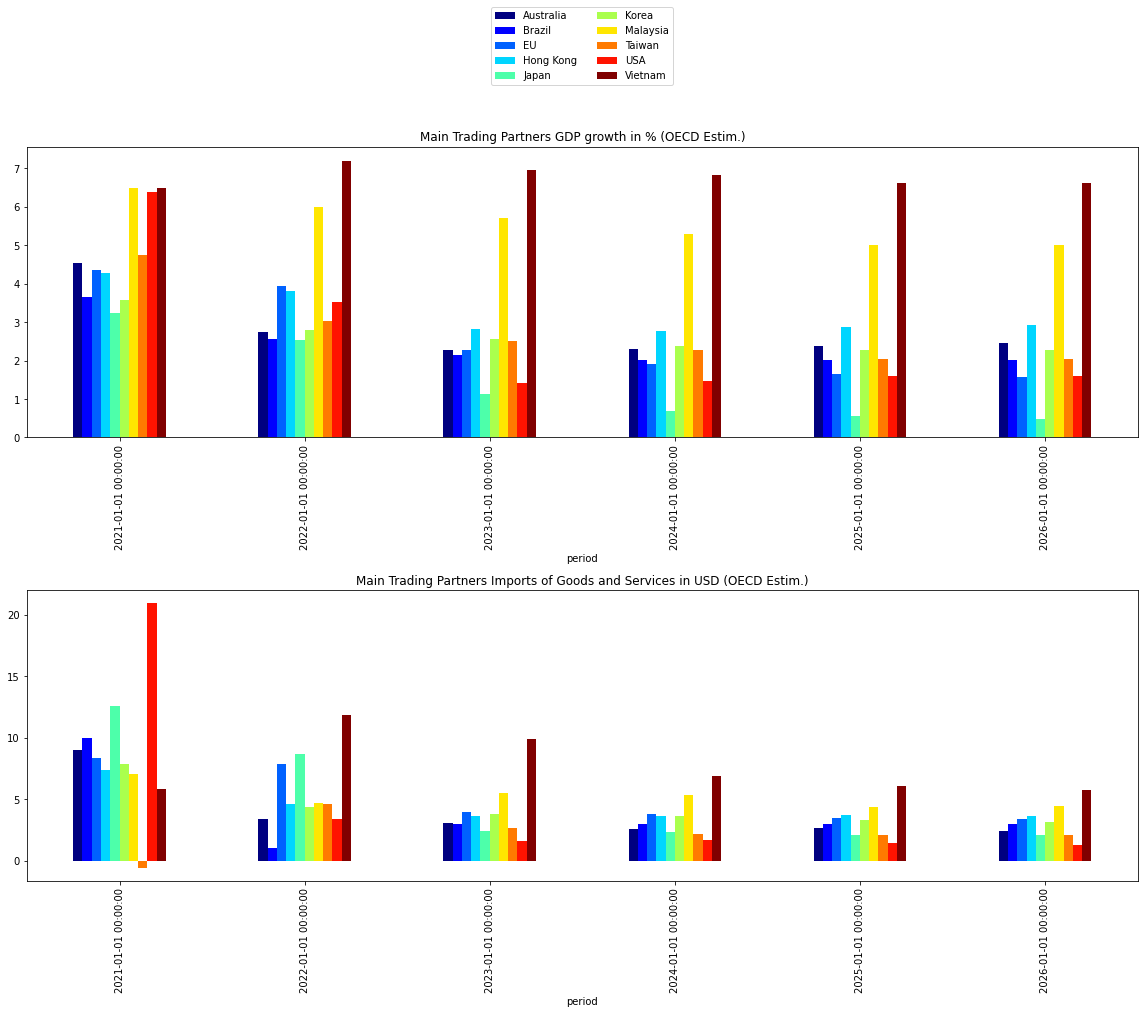

In [108]:
#Plot trading partners growth and imports forecasts
colors = plt.cm.jet(np.linspace(0, 1, 10))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,13))

ax = trad_part.plot(ax=axes[0], kind='bar', color=colors, stacked=False, legend=True, title='Main Trading Partners GDP growth in % (OECD Estim.)')

ax1 = trad_part_imp.plot(ax=axes[1], kind='bar', color=colors, stacked=False, legend=False, title='Main Trading Partners Imports of Goods and Services in USD (OECD Estim.)')

ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.subplots_adjust(bottom=0.6)

fig.tight_layout()

plt.show()

# Section 13: COVID-19 Analysis

In this section we are about to analyze the evolution of Covid-19 and its impact on the economy.

In [109]:
#Fetch covid-19 cases data for Chinese provinces
prov_list_cases = ['JHU/confirmed/CHN-beij', 
            'JHU/confirmed/CHN-guan', 
            'JHU/confirmed/CHN-hebe', 
            'JHU/confirmed/CHN-hena', 
            'JHU/confirmed/CHN-huna', 
            'JHU/confirmed/CHN-jian', 
            'JHU/confirmed/CHN-shan', 
            'JHU/confirmed/CHN-sich']

cases = pd.DataFrame()

for i in prov_list_cases:
    cases = cases.append(fetch_series(i)[['period', 'series_name', 'value']])
    
cases = cases.pivot(index='period', columns='series_name', values='value')

#Fetch covid-19 deaths data for Chinese provinces
prov_list_deaths = ['JHU/deaths/CHN-beij', 
            'JHU/deaths/CHN-guan', 
            'JHU/deaths/CHN-hebe', 
            'JHU/deaths/CHN-hena', 
            'JHU/deaths/CHN-huna', 
            'JHU/deaths/CHN-jian', 
            'JHU/deaths/CHN-shan', 
            'JHU/deaths/CHN-sich']

deaths = pd.DataFrame()

for i in prov_list_deaths:
    deaths = deaths.append(fetch_series(i)[['period', 'series_name', 'value']])
    
deaths = deaths.pivot(index='period', columns='series_name', values='value')

In [110]:
#Plot covid-19 data
plt.figure(figsize=(16,9))
fig = px.line(cases, x=cases.index, y=['China-Beijing', 'China-Guangdong', 'China-Hebei','China-Henan', 'China-Hunan', 'China-Jiangsu', 'China-Shandong', 'China-Sichuan'], title='Confirmed Cases')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

<Figure size 1152x648 with 0 Axes>

In [111]:
plt.figure(figsize=(16,9))
fig1 = px.line(deaths, x=deaths.index, y=['China-Beijing', 'China-Guangdong', 'China-Hebei','China-Henan', 'China-Hunan', 'China-Jiangsu', 'China-Shandong', 'China-Sichuan'], title='Deaths')
fig1.update_xaxes(rangeslider_visible=True)
fig1.show()

<Figure size 1152x648 with 0 Axes>

# Section 14: Climate Change Readiness and Vulnerability Analysis

In this section we will analyze the evolution of the readiness and vulnerability to climate changes of the country. We will specifically look at the ND-GAIN framework, even though data is available only up to 2019, so an educated guess has to be taken for the most current period and future expectations.

The Notre Dame-Global Adaptation Index (ND-GAIN) Country Index is a free opensource index that shows a country’s current vulnerability to climate disruptions. It also assesses a country’s readiness to leverage private and public sector investment for adaptive actions. ND-GAIN brings together over 74 variables to form 45 core indicators to measure vulnerability and readiness of 192 UN countries from 1995 to the present. All countries, to different extents, are facing the challenges of adaptation. Due to geographical location or socio-economic condition, some countries are more vulnerable to the impacts of climate change than others. Further, some countries are more ready to take on adaptation actions by leveraging public and private sector investments, through government action, community awareness, and the ability to facilitate private sector responses. ND-GAIN measures both of these dimensions:
vulnerability and readiness. 

For more information: https://gain.nd.edu/assets/254377/nd_gain_technical_document_2015.pdf

ND-GAIN’s framework breaks the measure of vulnerability into exposure, sensitivity and adaptive capacity, and the measure of readiness into economic, governance and social components. The construction of the ND-GAIN framework is based on published peer-reviewed material, the IPCC Review process, and feedback from corporate stakeholders, practitioners and development users.

In [112]:
#Fetch ND-GAIN index data and store them in a DataFrame
nd_gain_list = ['ND_GAIN/gain/A.USA', 
                'ND_GAIN/gain/A.AUS', 
                'ND_GAIN/gain/A.CAN', 
                'ND_GAIN/gain/A.CHN',
                'ND_GAIN/gain/A.DEU', 
                'ND_GAIN/gain/A.FRA', 
                'ND_GAIN/gain/A.GBR', 
                'ND_GAIN/gain/A.ITA', 
                'ND_GAIN/gain/A.JPN', 
                'ND_GAIN/gain/A.NZL']

nd_gain = pd.DataFrame()

for i in nd_gain_list:
    nd_gain = nd_gain.append(fetch_series(i)[['period', 'series_name', 'value']])
    
nd_gain = nd_gain.pivot(index='period', columns='series_name', values='value')

nd_gain.tail()

series_name  Annual – Australia  Annual – Canada  Annual – China  \
period                                                             
2015-01-01            70.520453        69.784502       53.045973   
2016-01-01            70.514831        69.268444       53.214818   
2017-01-01            69.851120        69.054408       53.834494   
2018-01-01            70.080946        68.368185       54.031530   
2019-01-01            69.863747        68.183637       57.203921   

series_name  Annual – France  Annual – Germany  Annual – Italy  \
period                                                           
2015-01-01         68.697363         71.702135       60.041291   
2016-01-01         68.083623         70.981536       59.770244   
2017-01-01         68.319847         70.840362       59.637638   
2018-01-01         68.175934         70.805065       60.342884   
2019-01-01         68.875286         70.561363       60.494706   

series_name  Annual – Japan  Annual – New Zealand  Annual – United Kingdom  \
period                                                                       
2015-01-01        68.598817             76.279972                71.899332   
2016-01-01        67.811165             75.728593                71.012710   
2017-01-01        68.162109             75.684566                70.595824   
2018-01-01        67.989624             75.535487                70.150924   
2019-01-01        67.878913             71.626151                70.231033   

series_name  Annual – United States  
period                               
2015-01-01                68.545424  
2016-01-01                66.922548  
2017-01-01                67.992118  
2018-01-01                67.803312  
2019-01-01                67.148960

In [113]:
#Rename columns of ND-GAIN DataFrame
columns = ['Australia', 'Canada', 'China', 'France', 'Germany', 'Italy', 'Japan', 'New Zealand', 'UK', 'USA']

nd_gain.columns = columns
nd_gain.tail()

Australia     Canada      China     France    Germany      Italy  \
period                                                                         
2015-01-01  70.520453  69.784502  53.045973  68.697363  71.702135  60.041291   
2016-01-01  70.514831  69.268444  53.214818  68.083623  70.981536  59.770244   
2017-01-01  69.851120  69.054408  53.834494  68.319847  70.840362  59.637638   
2018-01-01  70.080946  68.368185  54.031530  68.175934  70.805065  60.342884   
2019-01-01  69.863747  68.183637  57.203921  68.875286  70.561363  60.494706   

                Japan  New Zealand         UK        USA  
period                                                    
2015-01-01  68.598817    76.279972  71.899332  68.545424  
2016-01-01  67.811165    75.728593  71.012710  66.922548  
2017-01-01  68.162109    75.684566  70.595824  67.992118  
2018-01-01  67.989624    75.535487  70.150924  67.803312  
2019-01-01  67.878913    71.626151  70.231033  67.148960

In [114]:
#Plot ND-GAIN data for country comparison
plt.figure(figsize=(16,9))
fig2 = px.line(nd_gain, x=nd_gain.index, y=['Australia', 'Canada', 'China', 'France', 'Germany', 'Italy', 'Japan', 'New Zealand', 'UK', 'USA'], title='ND-GAIN')
fig2.update_xaxes(rangeslider_visible=True)
fig2.show()

<Figure size 1152x648 with 0 Axes>

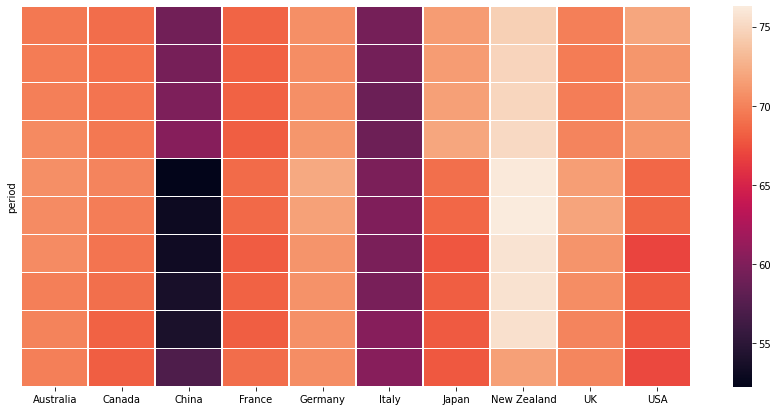

In [115]:
#Plot a heatmap to better assess the trend in the ND-GAIN index
plt.figure(figsize=(15,7))
ax = sns.heatmap(nd_gain.iloc[-10:], linewidths=.5, yticklabels=False)

In [116]:
#Fetch ND-GAIN Vulnerability and Readiness data
vulnerability = fetch_series('ND_GAIN/vulnerability/A.CHN')
vulnerability = clean_data(vulnerability, 'Vulnerability')

readiness = fetch_series('ND_GAIN/readiness/A.CHN')
readiness = clean_data(readiness, 'Readiness')

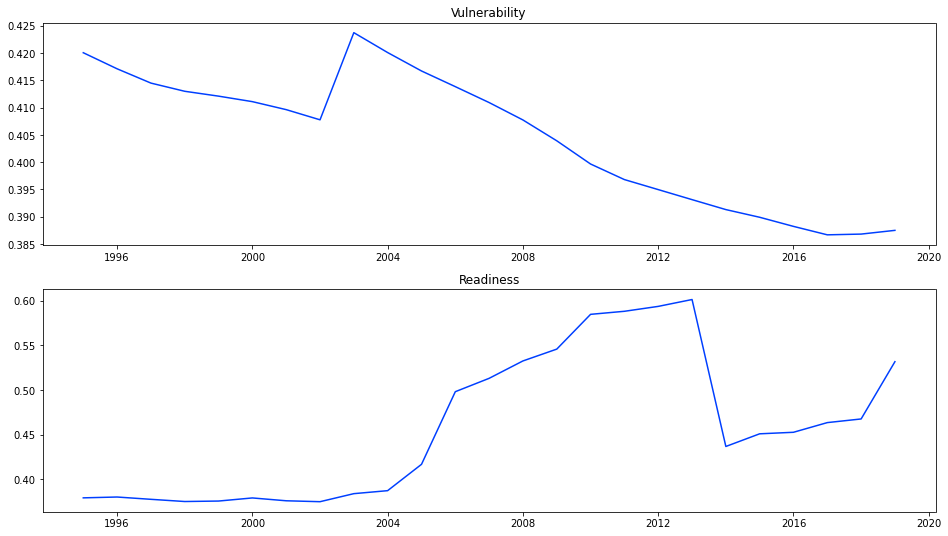

In [117]:
#Plot ND-GAIN Vulnerability and Readiness data
plt.subplots(figsize=(16,9))

plt.subplot(211)
plt.plot(vulnerability)
plt.title('Vulnerability')

plt.subplot(212)
plt.plot(readiness)
plt.title('Readiness')

plt.show()

Propensity or predisposition of human societies to be negatively impacted by climate hazards.

ND-GAIN assesses the vulnerability of a country by considering six life-supporting sectors: food, water, health, ecosystem services, human habitat and infrastructure. Each sector is in turn represented by six indicators that represent three cross-cutting components: the exposure of the sector to climate-related or climate-exacerbated hazards; the sensitivity of that sector to the impacts of the hazard and the adaptive capacity of the sector to cope or adapt to these impacts.

Exposure: The extent to which human society and its supporting sectors are stressed by the future changing climate conditions. Exposure in ND-GAIN captures the physical factors external to the system that contribute to vulnerability.

Sensitivity: The degree to which people and the sectors they depend upon are affected by climate related perturbations. The factors increasing sensitivity include the degree of dependency on sectors that are climate-sensitive and proportion of populations sensitive to climate hazard due to factors such as topography and demography. 

Adaptive capacity: The ability of society and its supporting sectors to adjust to reduce potential damage and to respond to the negative consequences of climate events. In ND-GAIN adaptive capacity indicators seek to capture a collection of means, readily deployable to deal with sector-specific climate change impacts.

In [118]:
#Fetch data for Vulnerability assessment
exposure = fetch_series('ND_GAIN/eposure/A.CHN')
exposure = clean_data(exposure, 'Exposure')

sensitivity = fetch_series('ND_GAIN/sensitivity/A.CHN')
sensitivity = clean_data(sensitivity, 'Sensitivity')

adapt_capac = fetch_series('ND_GAIN/capacity/A.CHN')
adapt_capac = clean_data(adapt_capac, 'Adaptive Capacity')

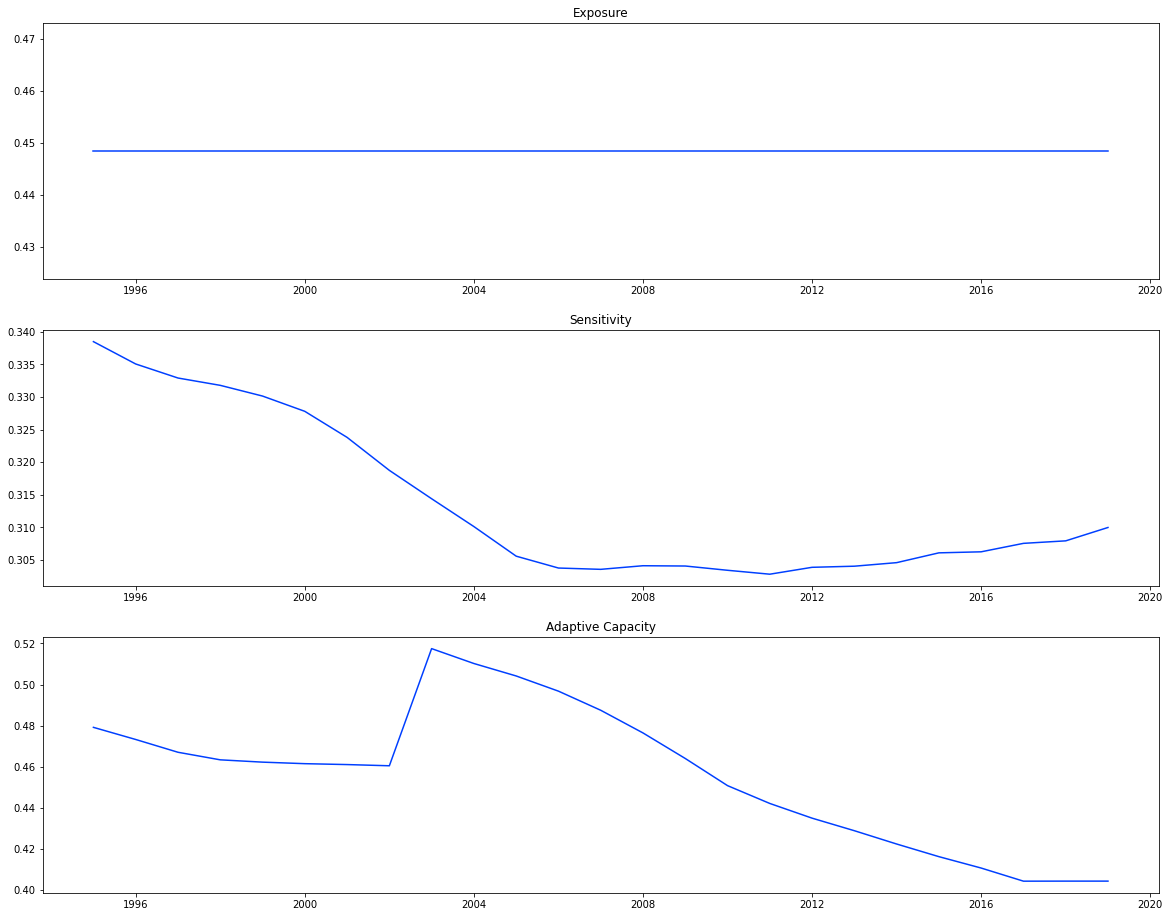

In [119]:
#Plot data for Vulnerability assessment
plt.subplots(figsize=(20,16))

plt.subplot(311)
plt.plot(exposure)
plt.title('Exposure')

plt.subplot(312)
plt.plot(sensitivity)
plt.title('Sensitivity')

plt.subplot(313)
plt.plot(adapt_capac)
plt.title('Adaptive Capacity')

plt.show()

In [120]:
#Fetch vulnerability-related data for each sector considered
food = fetch_series('ND_GAIN/food/A.CHN')
food = clean_data(food, 'Food')

water = fetch_series('ND_GAIN/water/A.CHN')
water = clean_data(water, 'Water')

health = fetch_series('ND_GAIN/health/A.CHN')
health = clean_data(health, 'Health')

ecosystem = fetch_series('ND_GAIN/ecosystems/A.CHN')
ecosystem = clean_data(ecosystem, 'Ecosystem')

habitat = fetch_series('ND_GAIN/habitat/A.CHN')
habitat = clean_data(habitat, 'Habitat')

infrastructure = fetch_series('ND_GAIN/infrastructure/A.CHN')
infrastructure = clean_data(infrastructure, 'Infrastructure')

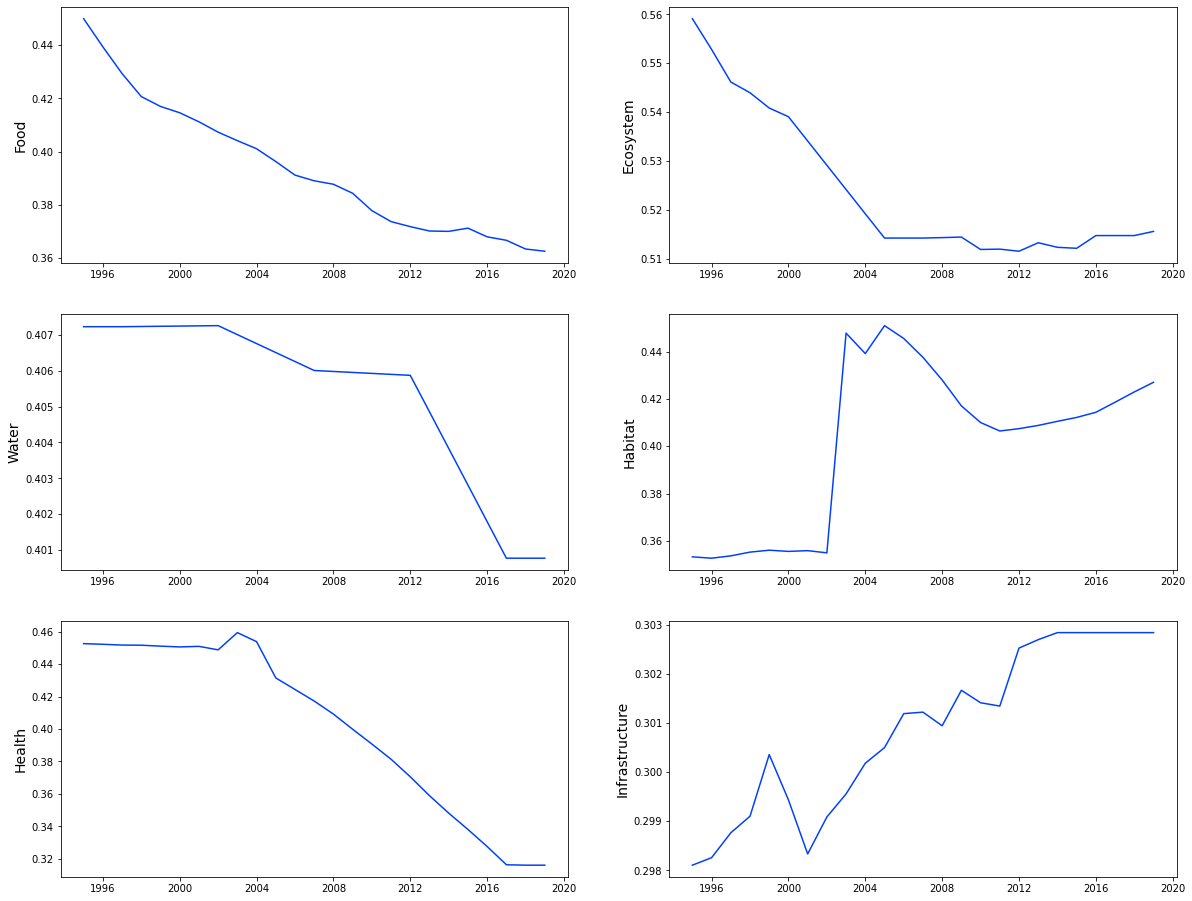

In [121]:
#Plot vulnerability-related data for each sector considered
fig, axs = plt.subplots(3, 2, figsize=(20, 16))

axs[0,0].plot(food)
axs[0,0].set_ylabel('Food', fontsize=14)

axs[1,0].plot(water)
axs[1,0].set_ylabel('Water', fontsize=14)

axs[2,0].plot(health)
axs[2,0].set_ylabel('Health', fontsize=14)

axs[0,1].plot(ecosystem)
axs[0,1].set_ylabel('Ecosystem', fontsize=14)

axs[1,1].plot(habitat)
axs[1,1].set_ylabel('Habitat', fontsize=14)

axs[2,1].plot(infrastructure)
axs[2,1].set_ylabel('Infrastructure', fontsize=14)

plt.show()

Readiness to make effective use of investments for adaptation actions thanks to a safe and efficient business environment ND-GAIN measures readiness by considering a country’s ability to leverage investments to adaptation actions. 

ND-GAIN measures overall readiness by considering three components: economic readiness, governance readiness and social readiness. 

Economic Readiness: The investment climate that facilitates mobilizing capitals from private sector.

Governance Readiness: The stability of the society and institutional arrangements that contribute to the investment risks. A stable country with high governance capacity reassures investors that the invested capitals could grow under the help of responsive public services and without significant interruption.

Social readiness: Social conditions that help society to make efficient and equitable use of investment and yield more benefit from the investment

In [122]:
#Fetch data for Readiness assessment
economic = fetch_series('ND_GAIN/economic/A.CHN')
economic = clean_data(economic, 'Economic')

governance = fetch_series('ND_GAIN/governance/A.CHN')
governance = clean_data(governance, 'Governance')

social = fetch_series('ND_GAIN/social/A.CHN')
social = clean_data(social, 'Social')

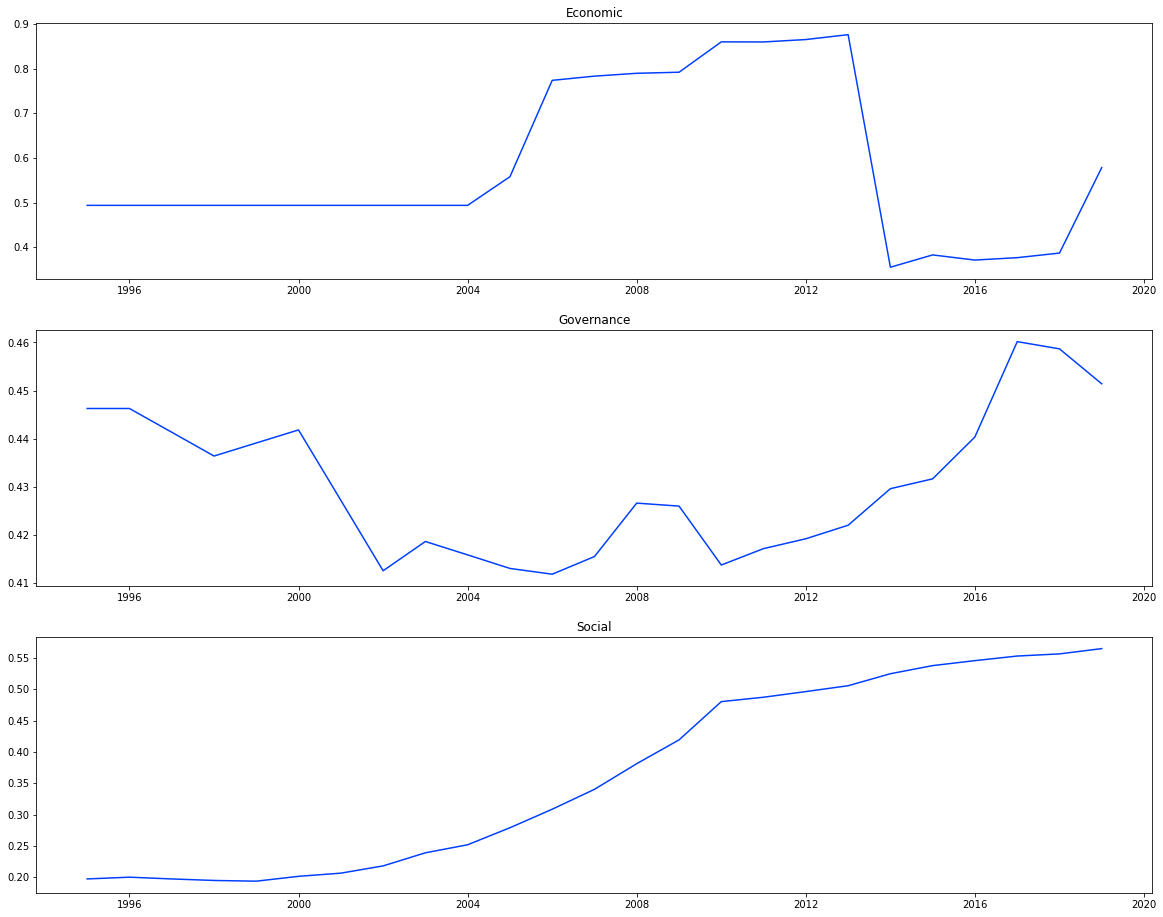

In [123]:
#Plot data for Readiness assessment
plt.subplots(figsize=(20,16))

plt.subplot(311)
plt.plot(economic)
plt.title('Economic')

plt.subplot(312)
plt.plot(governance)
plt.title('Governance')

plt.subplot(313)
plt.plot(social)
plt.title('Social')

plt.show()

# Section 15: Risk Assessment Matrix

|Nature of risk | Source of Risk |Most Direct Indicators | Likelihood of Severe Impact |
|:- | :- |:-| :-|
|Domestic | Growth | TFP, Labour, Capital, Agg. Demand, Covid-19 Stats. | Medium |
|External | Growth | Trading Partners Analysis| Low |
|Domestic | Monetary / Inflation | Output Gap, Inflation Expectations, Money Overhang | Medium |
|Domestic | Fiscal | Fiscal Stance and Impulse, Fiscal Sustainability| Low |
|Domestic |Financial Sector | FSI | Medium |
|External |External Trade | External Sector Indicators | Medium |
|External |External Financial | EBA | Low |
|External |Trade / Financial | ARA | Low |
|Global | Climate Change | ND-GAIN | High |

### Final comment

From the Risk Assessment Matrix we can claim that the overall risk is "medium". In fact, China is undergoing a period of decreasing productivity, especially with regard to the labor stock: this is confirmed by the fact that the participation rate is declining consistently and the labor factor is below the equilibrium level. Also, the crackdown on private companies (from tech to education, from crypto to real estate) can weigh on total factor productivity in the coming periods and reduce investos' confidence in the growth prospects of the country. The growth of Chinese output should stabilize in 2022 after a remarkable rebound in 2021 (even if recent revisions of such figure point at a smaller growth of GDP, due to recent real estate woes and energy prices spikes). Nevertheless, growth remains strong, with a potential positive output gap. Investments still contribute to around half of aggregate demand, with private consumption being the other biggest contributor. Despite having data up to 2019 only, the recent figures on consumer confidence depicts current worries of households for the future months, as cost of energy are rising and a potential bubble in the real estate sector is weighing on consumption. As to inflation, current CPI figures shows it is below the 3% target, but PPI data are skyrocketing to multi-decades highs, reflecting the high cost of raw materials and energy. This could negatively affect growth, but the divergence between CPI and PPI means the PBoC has more room to ease monetary policy should the real estate crisis worsen (housing prices are at historical highs, but are declining down after the government imposed curbs, i.e. the "three red lines"). In fact, current monetary policy seems quite accomodative even if more neutral than before, with money overhang still in positive territory. Nevertheless, PBoC recently injected liquidity into the system to avoid escalating turmoil in the banking system following the default of Evergrande, one of the major real estate developers of the country. No big issues seem to emerge from the financial system so far, but of course the situation has to be monitored in the coming months, as NPL can increase dramatically, should more defaults on the real estate occur. On the fiscal side, we can expect the debt to GDP ratio to climb in the coming years, as the government will need to boost investments while supporting the recovery from the pandemic. We can expect though that it will plateau around 85% in 4-5 years. After a spike of the current account during the pandemic in 2020, we can expect that it will decline in the coming years, as exports should weigh less on growth, considering that China will rely more on its domestic market to grow. The country is still the "factory of the wolrd", but this role will be challenged in the future, as the recent tax deal and supply-chain constraints should push governments to reconsider their strategies. Furthermore, the PBoC can tolerate a stronger yuan now and this will further decrease the effect of exports on Chinese GDP. The Reserve Adequacy Assessment (ARA) shows that the country has still enough foreign reserves to face external shocks, according to the IMF guidelines, and its main trading partners are expected to grow in the coming years, therefore reducing potential external risks. As to Covid-19, data from JHU are showing a flattening of cases and deaths, but as many other reported figures on this country, these data should be taken with a grain of salt. Plus, the efficacy of Chinese vaccines seems not to be as reliable as Western ones. Finally, with regard to climate change issues, China seems to have improved its readiness and vulnerability compared to 5 years ago, but compared to other countries there still room to go. Furthermore, the recent energy crisis may derail Chinese plans to achieve its emissions reduction targets, with the reactivation of coal-fueled plants.    